# DAT540 Introduction to Data Science
## University of Stavanger
### Project 03: New York stock exchange 
#### Group 06 members:
    - KADKHODAMASOUMAli Sahar
    - PALECZNY Ronald

### <u>Problematics</u>:

* Description of stock options by sector
* Anomaly detection of data
* Prediction of one selected stock option for the next year (Geometric Ornstein–Uhlenbeck Process Model Model)
* Prediction of one selected stock option for the next 90 days (Linear regression Model)
* Prediction of one selected stock option for the next two years (Long Short Term Memory Model)
* Prediction of one selected stock option for the next 90 days (SARIMAX Model)


### <u>Presentation of the dataset</u>:

* URL link: https://www.kaggle.com/dgawlik/nyse
* This dataset includes stock prices for various New York Stock Exchange companies. The dataset consists of the following files:

* `prices.csv`: raw, as-is daily prices. Most of the Data spans from 2010 to the end of 2016; for companies, the new stock market date range is shorter. There have been approx. 140 stock splits in that time; this set doesn't account for that.
* `prices-split-adjusted.csv`: same as prices, but there have been added adjustments for splits. 
* `securities.csv`: a general description of each company with the division on sectors
* `fundamentals.csv`: metrics extracted from annual SEC 10K fillings (2012-2016) should be enough to derive most of the popular fundamental indicators.

### <u>References</u>:

* https://www.kaggle.com/datasets/dgawlik/nyse?datasetId=854

* UiS course: MOD5550

* https://www.kaggle.com/code/nehahatti/stock-price-prediction-project

* https://www.askpython.com/python/examples/stock-price-prediction-python

### <u>Description of variables selected for the project</u>:

* `date`: string
* `close`: float64
* `symbol`: string
* `volume`: float64
* `GICS Sector`: string
* `year`: int

### <u>Methodology</u>:

* Data loading
    * Collect data files
    * Join data files (if needed)
* Data cleaning
    * Delete Duplicates
    * Manage NaN values
* Data preparation
    * Rename variables (columns)
    * Check if the following rules are respected:
        * Each variable represents one single column and has values
        * each observation represent a row
* Graphics
    * Choose the good type of graphic in accordance with the subject
    * Analyze the result of each graphic
    * Find the correlation between selected parameters
* Prediction
    * Choose a model based on the dataset and your problem statement.
    * Tune the parameters of the model.
    * Make predictions regarding the future values for some of your chosen variables.
    * Evaluate the model based on different metrics.
    * Justify each of the design decisions made. 
* Conclusion




    Plan:
1. Data loading
2. Data cleaning
3. Anomaly detection of data
4. Data preparation
5. Graphics
    
    5.1. Overview of stock options by sector
    
    5.2. Focus on "Consumer Discretionary" GICS sector (large number of outliers)
    * Do we have a correlation between close and volume ?

    5.3. Focus on "Telecommunications Services" GICS sector (no outlier)
    * Do we have a correlation between close and volume ?

    5.4. Focus on volume

6. Prediction Modeling

    6.1. Geometric Ornstein–Uhlenbeck Process Model (1 year)

    6.2. Linear regression Model (90 days)

    6.3. Long Short Term Memory Model (2 years)
    6.4. SARIMAX Model (90 days)

7. Conclusion

In [7]:
# Librairies needed for the project
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import groupby
import plotly.graph_objects as go
import copy
import scipy.stats as ss
#from scipy.stats.stats import pearsonr
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.preprocessing import MinMaxScaler
import random
from adtk.visualization import plot
from statsmodels.tsa.seasonal import seasonal_decompose
from project_utils import create_date_index, fillup_days, seasonal_anomaly_detector,threshhold_anomaly_detector, train_test_Split, best_model_order,  sarimax_model,best_model

In [4]:
# increase the size of all graphics
plt.rcParams['figure.figsize'] = [12, 8] # [width, height]
plt.rcParams['figure.dpi'] = 100 # resolution increasing with number

## 1. Data loading

In [5]:
df_fundamental = pd.read_csv('./data/fundamentals.csv')
df_adjusted = pd.read_csv('./data/prices-split-adjusted.csv')
df_prices = pd.read_csv('./data/prices.csv')
df_securities = pd.read_csv('./data/securities.csv')

In [6]:
print(df_fundamental.shape)
df_fundamental.head()

(1781, 79)


Unnamed: 0 Ticker Symbol Period Ending  Accounts Payable  \
0           0           AAL    2012-12-31      3.068000e+09   
1           1           AAL    2013-12-31      4.975000e+09   
2           2           AAL    2014-12-31      4.668000e+09   
3           3           AAL    2015-12-31      5.102000e+09   
4           4           AAP    2012-12-29      2.409453e+09   

   Accounts Receivable  Add'l income/expense items  After Tax ROE  \
0         -222000000.0               -1.961000e+09           23.0   
1          -93000000.0               -2.723000e+09           67.0   
2         -160000000.0               -1.500000e+08          143.0   
3          352000000.0               -7.080000e+08          135.0   
4          -89482000.0                6.000000e+05           32.0   

   Capital Expenditures  Capital Surplus  Cash Ratio  ...  \
0         -1.888000e+09     4.695000e+09        53.0  ...   
1         -3.114000e+09     1.059200e+10        75.0  ...   
2         -5.311000e+09     1.513500e+10        60.0  ...   
3         -6.151000e+09     1.159100e+10        51.0  ...   
4         -2.711820e+08     5.202150e+08        23.0  ...   

   Total Current Assets  Total Current Liabilities  Total Equity  \
0          7.072000e+09               9.011000e+09 -7.987000e+09   
1          1.432300e+10               1.380600e+10 -2.731000e+09   
2          1.175000e+10               1.340400e+10  2.021000e+09   
3          9.985000e+09               1.360500e+10  5.635000e+09   
4          3.184200e+09               2.559638e+09  1.210694e+09   

   Total Liabilities  Total Liabilities & Equity  Total Revenue  \
0       2.489100e+10                1.690400e+10   2.485500e+10   
1       4.500900e+10                4.227800e+10   2.674300e+10   
2       4.120400e+10                4.322500e+10   4.265000e+10   
3       4.278000e+10                4.841500e+10   4.099000e+10   
4       3.403120e+09                4.613814e+09   6.205003e+09   

   Treasury Stock  For Year  Earnings Per Share  Estimated Shares Outstanding  
0    -367000000.0    2012.0               -5.60                  3.350000e+08  
1             0.0    2013.0              -11.25                  1.630222e+08  
2             0.0    2014.0                4.02                  7.169154e+08  
3             0.0    2015.0               11.39                  6.681299e+08  
4     -27095000.0    2012.0                5.29                  7.328355e+07  

[5 rows x 79 columns]

In [8]:
df_fundamental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 79 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Unnamed: 0                                           1781 non-null   int64  
 1   Ticker Symbol                                        1781 non-null   object 
 2   Period Ending                                        1781 non-null   object 
 3   Accounts Payable                                     1781 non-null   float64
 4   Accounts Receivable                                  1781 non-null   float64
 5   Add'l income/expense items                           1781 non-null   float64
 6   After Tax ROE                                        1781 non-null   float64
 7   Capital Expenditures                                 1781 non-null   float64
 8   Capital Surplus                                      1781 non-null  

In [9]:
# name of columns
df_fundamental.columns

Index(['Unnamed: 0', 'Ticker Symbol', 'Period Ending', 'Accounts Payable',
       'Accounts Receivable', 'Add'l income/expense items', 'After Tax ROE',
       'Capital Expenditures', 'Capital Surplus', 'Cash Ratio',
       'Cash and Cash Equivalents', 'Changes in Inventories', 'Common Stocks',
       'Cost of Revenue', 'Current Ratio', 'Deferred Asset Charges',
       'Deferred Liability Charges', 'Depreciation',
       'Earnings Before Interest and Tax', 'Earnings Before Tax',
       'Effect of Exchange Rate',
       'Equity Earnings/Loss Unconsolidated Subsidiary', 'Fixed Assets',
       'Goodwill', 'Gross Margin', 'Gross Profit', 'Income Tax',
       'Intangible Assets', 'Interest Expense', 'Inventory', 'Investments',
       'Liabilities', 'Long-Term Debt', 'Long-Term Investments',
       'Minority Interest', 'Misc. Stocks', 'Net Borrowings', 'Net Cash Flow',
       'Net Cash Flow-Operating', 'Net Cash Flows-Financing',
       'Net Cash Flows-Investing', 'Net Income', 'Net Income Ad

    Observation:
It's difficult to understand the signification of each column without financial background...

In [10]:
df_fundamental.nunique() 

Unnamed: 0                      1781
Ticker Symbol                    448
Period Ending                    162
Accounts Payable                1676
Accounts Receivable             1329
                                ... 
Total Revenue                   1757
Treasury Stock                  1015
For Year                           6
Earnings Per Share               744
Estimated Shares Outstanding    1558
Length: 79, dtype: int64

In [11]:
print(df_adjusted.shape)
df_adjusted.head()

(851264, 7)


date symbol        open       close         low        high  \
0  2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0

In [12]:
df_adjusted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [13]:
# number of unique values per column
df_adjusted.nunique() 

date        1762
symbol       501
open       97522
close      98520
low        97470
high       97784
volume    171073
dtype: int64

    Observation:
* There is 501 different stock options in the dataset df_adjusted

In [14]:
print(df_prices.shape)
df_prices.head()

(851264, 7)


date symbol        open       close         low        high  \
0  2016-01-05 00:00:00   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06 00:00:00   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07 00:00:00   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08 00:00:00   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11 00:00:00   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0

In [15]:
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [16]:
# number of unique values per column
df_prices.nunique() 

date        3524
symbol       501
open       72707
close      73628
low        72900
high       73299
volume    171073
dtype: int64

    Observation:
* There is 501 different stock options in the dataframe `df_prices`
* The dataframe `df_prices` and `df_adjusted` look similar in aspect of variables not values.
* For the project, we select `df_prices` in order to have the real data

In [17]:
print(df_securities.shape)
df_securities.head()

(505, 8)


Ticker symbol             Security SEC filings             GICS Sector  \
0           MMM           3M Company     reports             Industrials   
1           ABT  Abbott Laboratories     reports             Health Care   
2          ABBV               AbbVie     reports             Health Care   
3           ACN        Accenture plc     reports  Information Technology   
4          ATVI  Activision Blizzard     reports  Information Technology   

                GICS Sub Industry   Address of Headquarters Date first added  \
0        Industrial Conglomerates       St. Paul, Minnesota              NaN   
1           Health Care Equipment   North Chicago, Illinois       1964-03-31   
2                 Pharmaceuticals   North Chicago, Illinois       2012-12-31   
3  IT Consulting & Other Services           Dublin, Ireland       2011-07-06   
4     Home Entertainment Software  Santa Monica, California       2015-08-31   

       CIK  
0    66740  
1     1800  
2  1551152  
3  1467373  
4   718877

In [18]:
df_securities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Ticker symbol            505 non-null    object
 1   Security                 505 non-null    object
 2   SEC filings              505 non-null    object
 3   GICS Sector              505 non-null    object
 4   GICS Sub Industry        505 non-null    object
 5   Address of Headquarters  505 non-null    object
 6   Date first added         307 non-null    object
 7   CIK                      505 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 31.7+ KB


In [19]:
# number of unique values per column
df_securities.nunique() 

Ticker symbol              505
Security                   504
SEC filings                  1
GICS Sector                 11
GICS Sub Industry          124
Address of Headquarters    264
Date first added           252
CIK                        500
dtype: int64

    Observation:
* There is 11 different sectors and 505 different stock options in the dataframe `df_securities`

In [20]:
df_adjusted.describe()

open          close            low           high  \
count  851264.000000  851264.000000  851264.000000  851264.000000   
mean       64.993618      65.011913      64.336541      65.639748   
std        75.203893      75.201216      74.459518      75.906861   
min         1.660000       1.590000       1.500000       1.810000   
25%        31.270000      31.292776      30.940001      31.620001   
50%        48.459999      48.480000      47.970001      48.959999   
75%        75.120003      75.139999      74.400002      75.849998   
max      1584.439941    1578.130005    1549.939941    1600.930054   

             volume  
count  8.512640e+05  
mean   5.415113e+06  
std    1.249468e+07  
min    0.000000e+00  
25%    1.221500e+06  
50%    2.476250e+06  
75%    5.222500e+06  
max    8.596434e+08

    Observation:

There is 
* 448 unique stock options in the dataframe `df_fundamental`
* 501 unique stock options in the dataframe `df_prices`
* 505 unique stock options in the dataframe `df_securities`
`

This should be considered if we need to merge two dataframes

## 2. Data cleaning

In [21]:
df_fundamental.duplicated().sum(axis=0)

0

In [25]:
df_prices.duplicated().sum(axis=0)

0

In [23]:
df_securities.duplicated().sum(axis=0)

0

    Observation:
There is no duplicates in the dataframes

In [26]:
df_fundamental.isnull().sum(axis=0)

Unnamed: 0                        0
Ticker Symbol                     0
Period Ending                     0
Accounts Payable                  0
Accounts Receivable               0
                               ... 
Total Revenue                     0
Treasury Stock                    0
For Year                        173
Earnings Per Share              219
Estimated Shares Outstanding    219
Length: 79, dtype: int64

In [27]:
df_prices.isnull().sum(axis=0)

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [28]:
df_securities.isnull().sum(axis=0)

Ticker symbol                0
Security                     0
SEC filings                  0
GICS Sector                  0
GICS Sub Industry            0
Address of Headquarters      0
Date first added           198
CIK                          0
dtype: int64

    Observation:
Several variables from dataframe `df_fundamental` (ex: For year, Earning Per Share, Estimated Shares Outstanding...) and `df_securities` (Date first added) have missing values. 

This must be taken into account if using these variables.

## 3. Anomaly detection of data 

In [29]:
# Selecting the symbole
symbole = "AMZN"
df_prices_sym=df_prices[df_prices['symbol']== symbole].copy()

# Creating the close_change paramtere
df_prices_sym['close_change'] = ((df_prices_sym['close'] - df_prices_sym['close'].shift(1)) / df_prices_sym['close'].shift(1))
df_prices_sym = df_prices_sym.iloc[1: , :]

The Index of dataframe is now date with the type of <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
There are 790 days without data. These days will be filled up using forward filling method...
Non-trading days filled up. The dataframe has now 2552 records


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

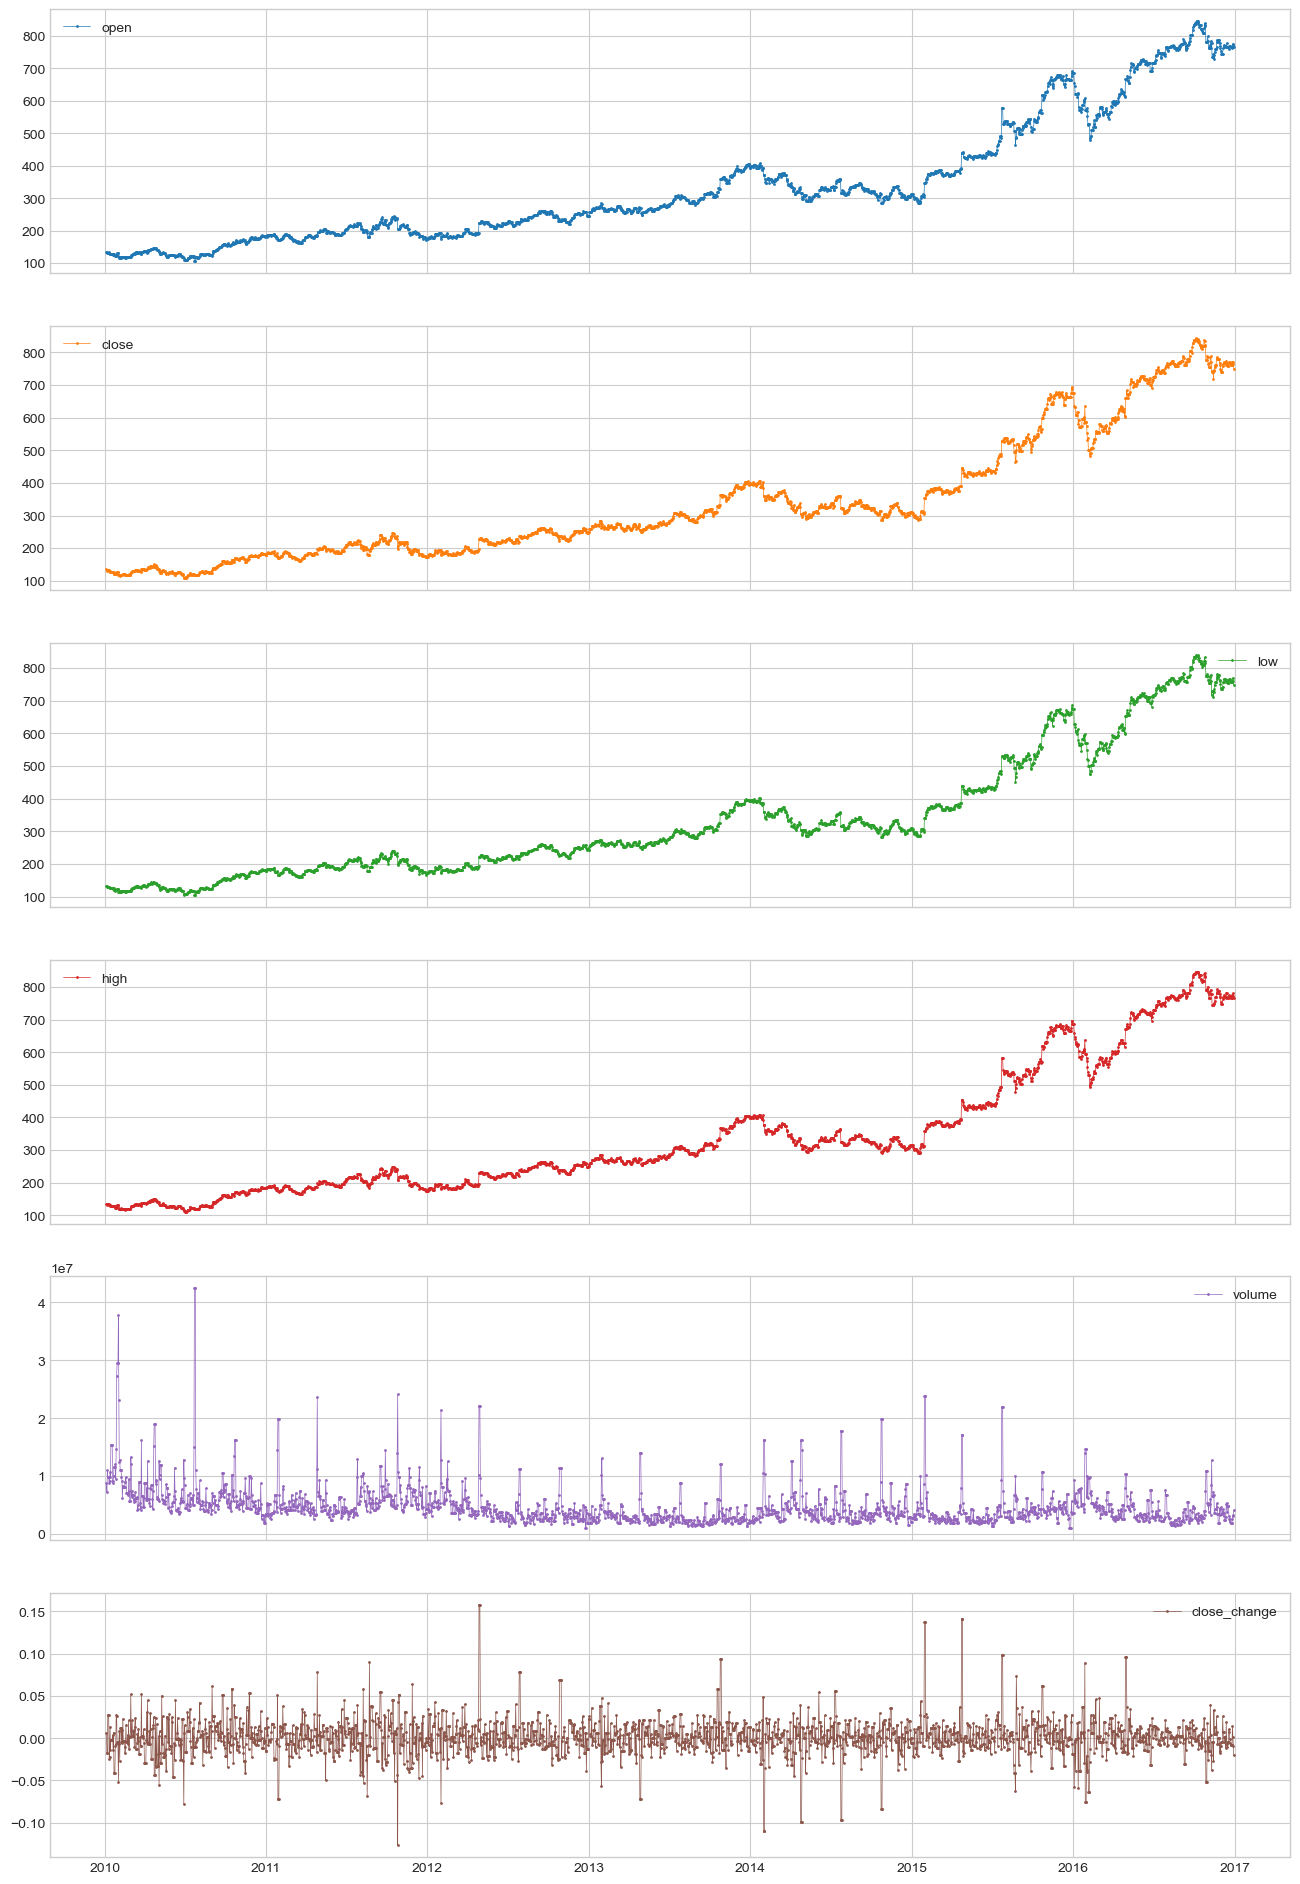

In [30]:
# Changing the index of df to date
df_prices_sym = create_date_index (df_prices_sym)

# Fill up the days without trading
df_prices_sym = fillup_days(df_prices_sym)

# plot different paramter of the df
plot(df_prices_sym)

    Observation:
-In these graphics, all variables are shown during history (days with non_values due to weekend or close days of stock market were filled with data of previous day).

69 records are detected as volume seasonal anomaly.
volume_seasonal_anomaly column was added to dataframe.


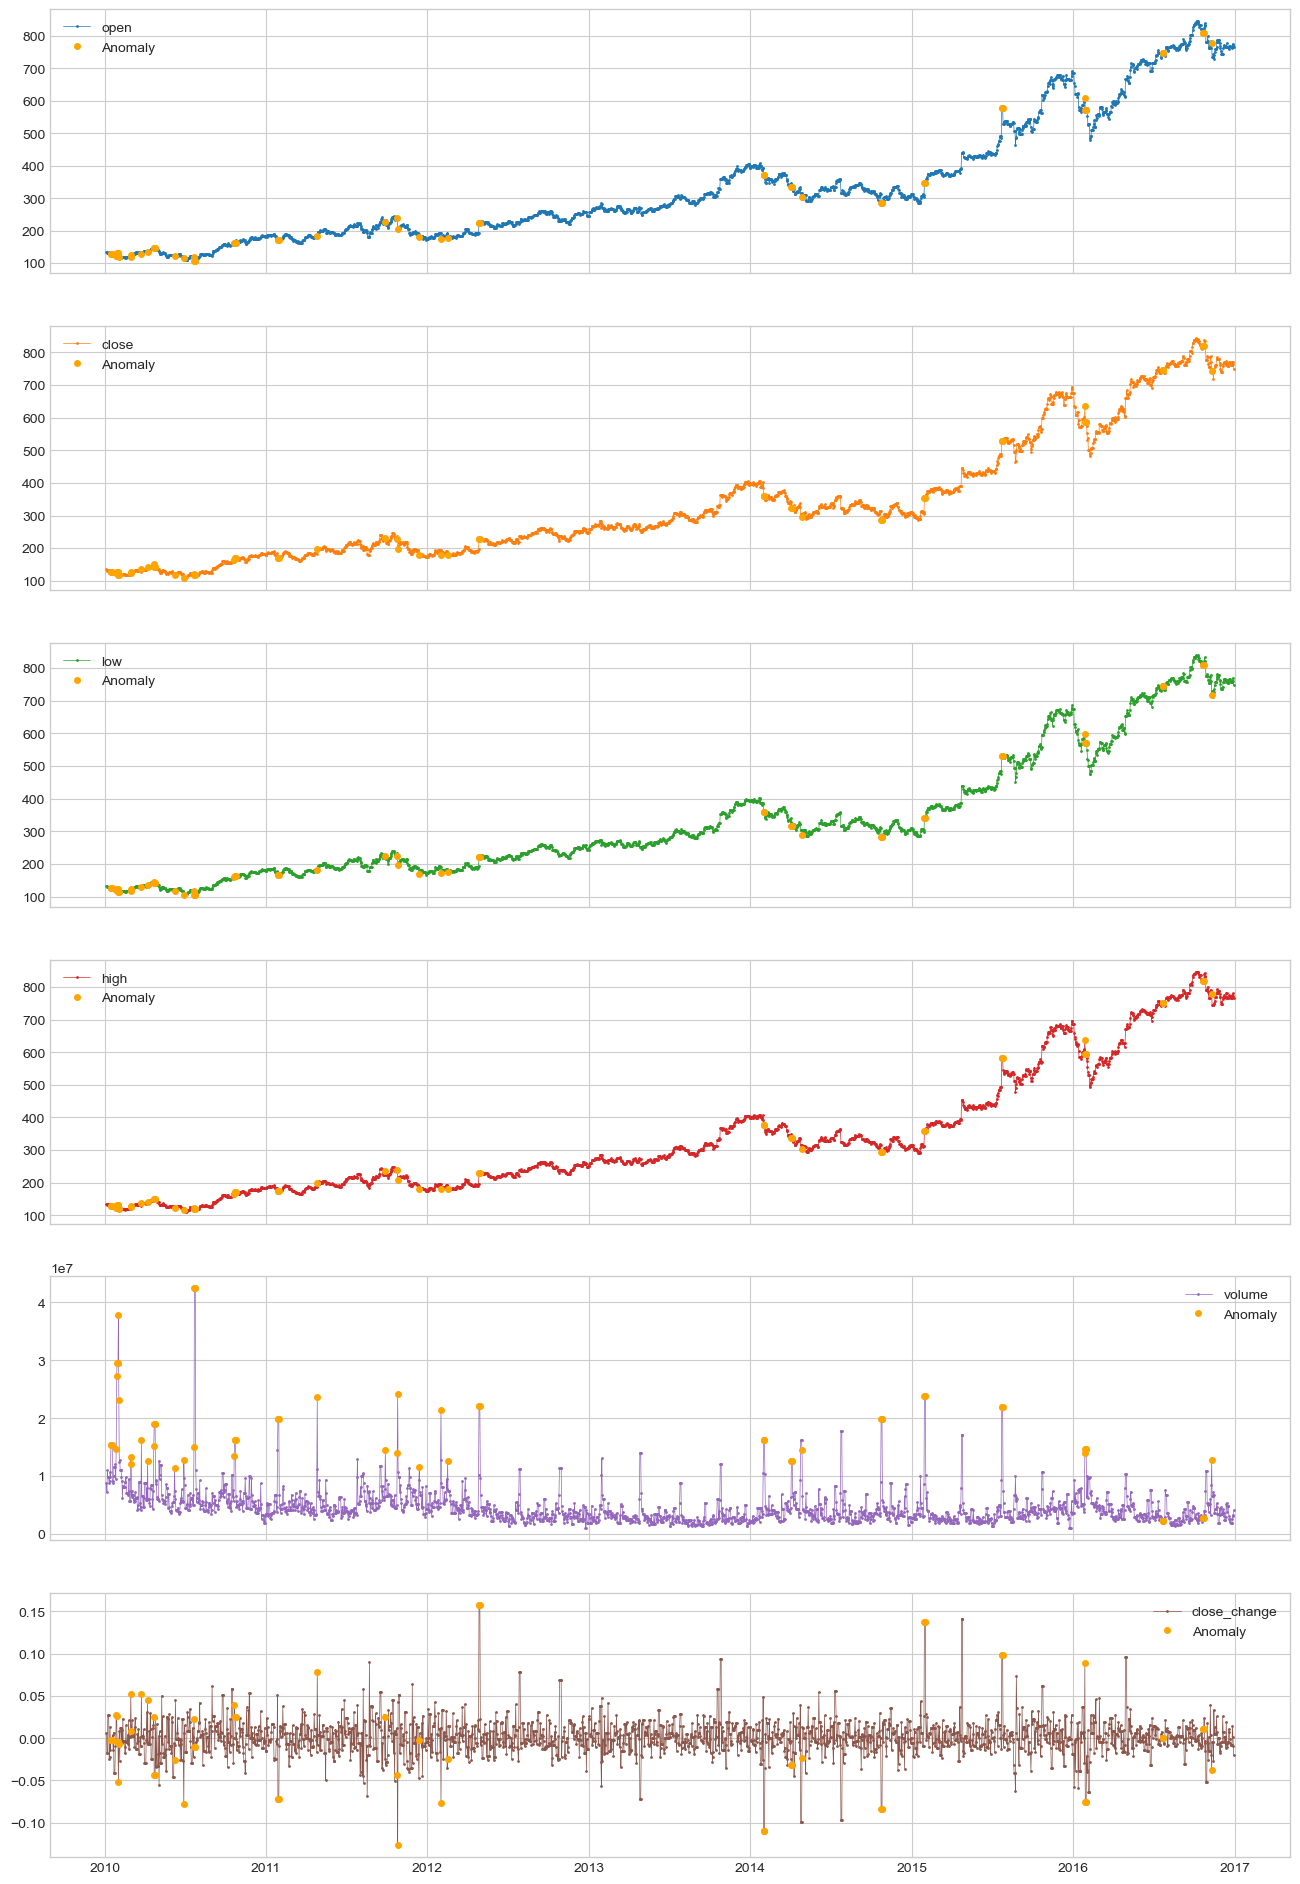

In [32]:
# Checking the seasonal anomaly of volume
df_prices_sym = seasonal_anomaly_detector(df_prices_sym, parameter='volume')

    Observation: 
In this figure, anomalies are:
* based on ´volume´ variable and,
* projected on the other figures (other variables).

In [33]:
# Checking the seasonal anomaly of close
df_prices_sym =  seasonal_anomaly_detector(df_prices_sym, 'close')

Could not find significant seasonality. No column was added.


    Observation: 
´close´variable does not show any seasonality. So anomaly can not find for it.

In [34]:
# Checking the seasonal anomaly of close_change
df_prices_sym =  seasonal_anomaly_detector(df_prices_sym, 'close_change')

Could not find significant seasonality. No column was added.


High threshhold for volume is set to 11630158.77
Low threshhold for volume is set to -2122045.91
90 records are detected as volume threshhold anomaly.
volume_threshhold_anomaly column was added to dataframe.


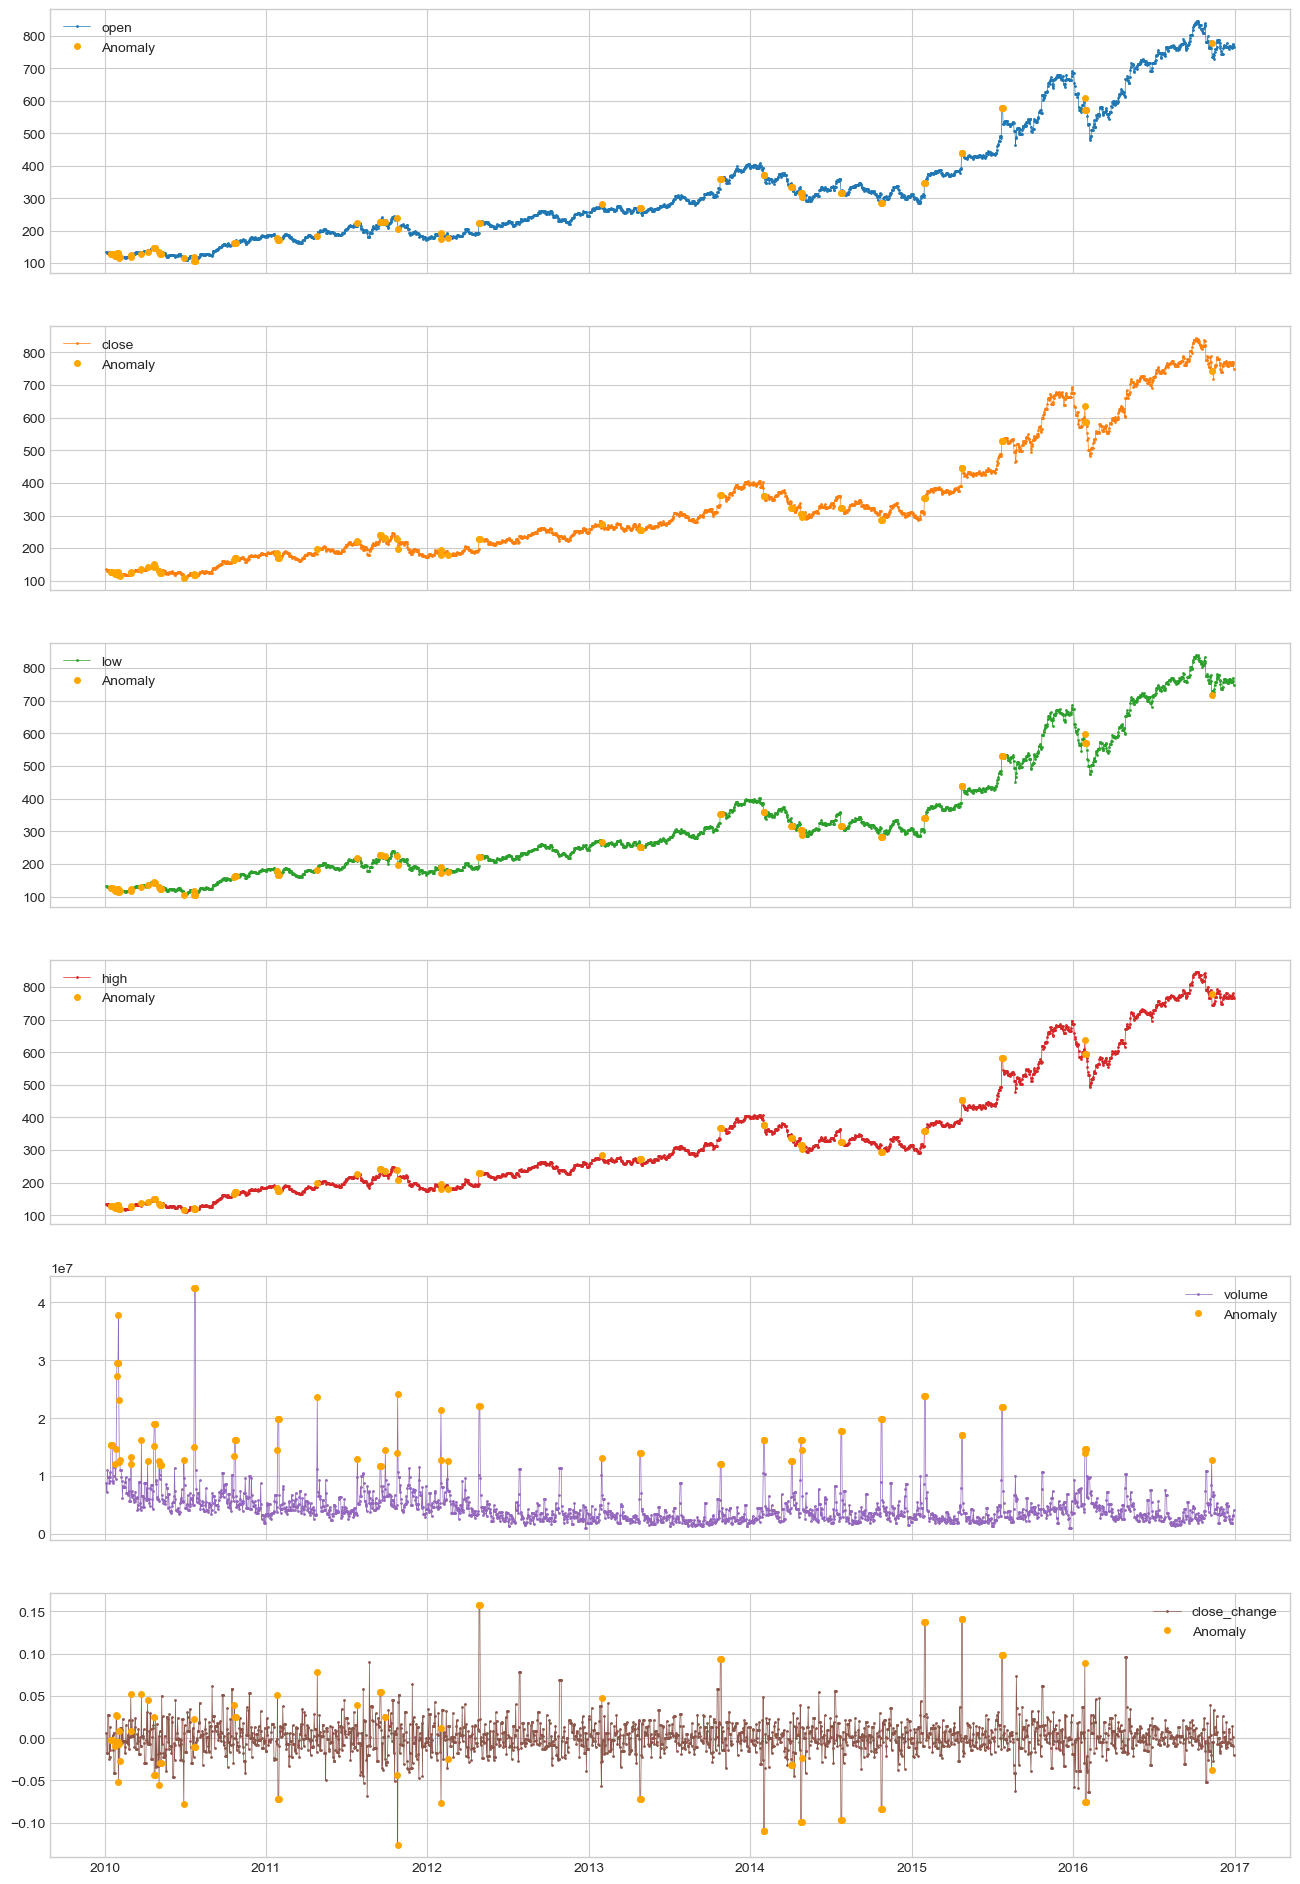

In [35]:
# Checking the threshhold anomaly of volume
df_prices_sym = threshhold_anomaly_detector (df_prices_sym, parameter= 'volume', sd_threshhold=2)

    Observation: 
Based on threshhold method anomalies were found for ´volume´variable and projected on other variables´s figures.

High threshhold for close_change is set to 0.05
Low threshhold for close_change is set to -0.04
113 records are detected as close_change threshhold anomaly.
close_change_threshhold_anomaly column was added to dataframe.


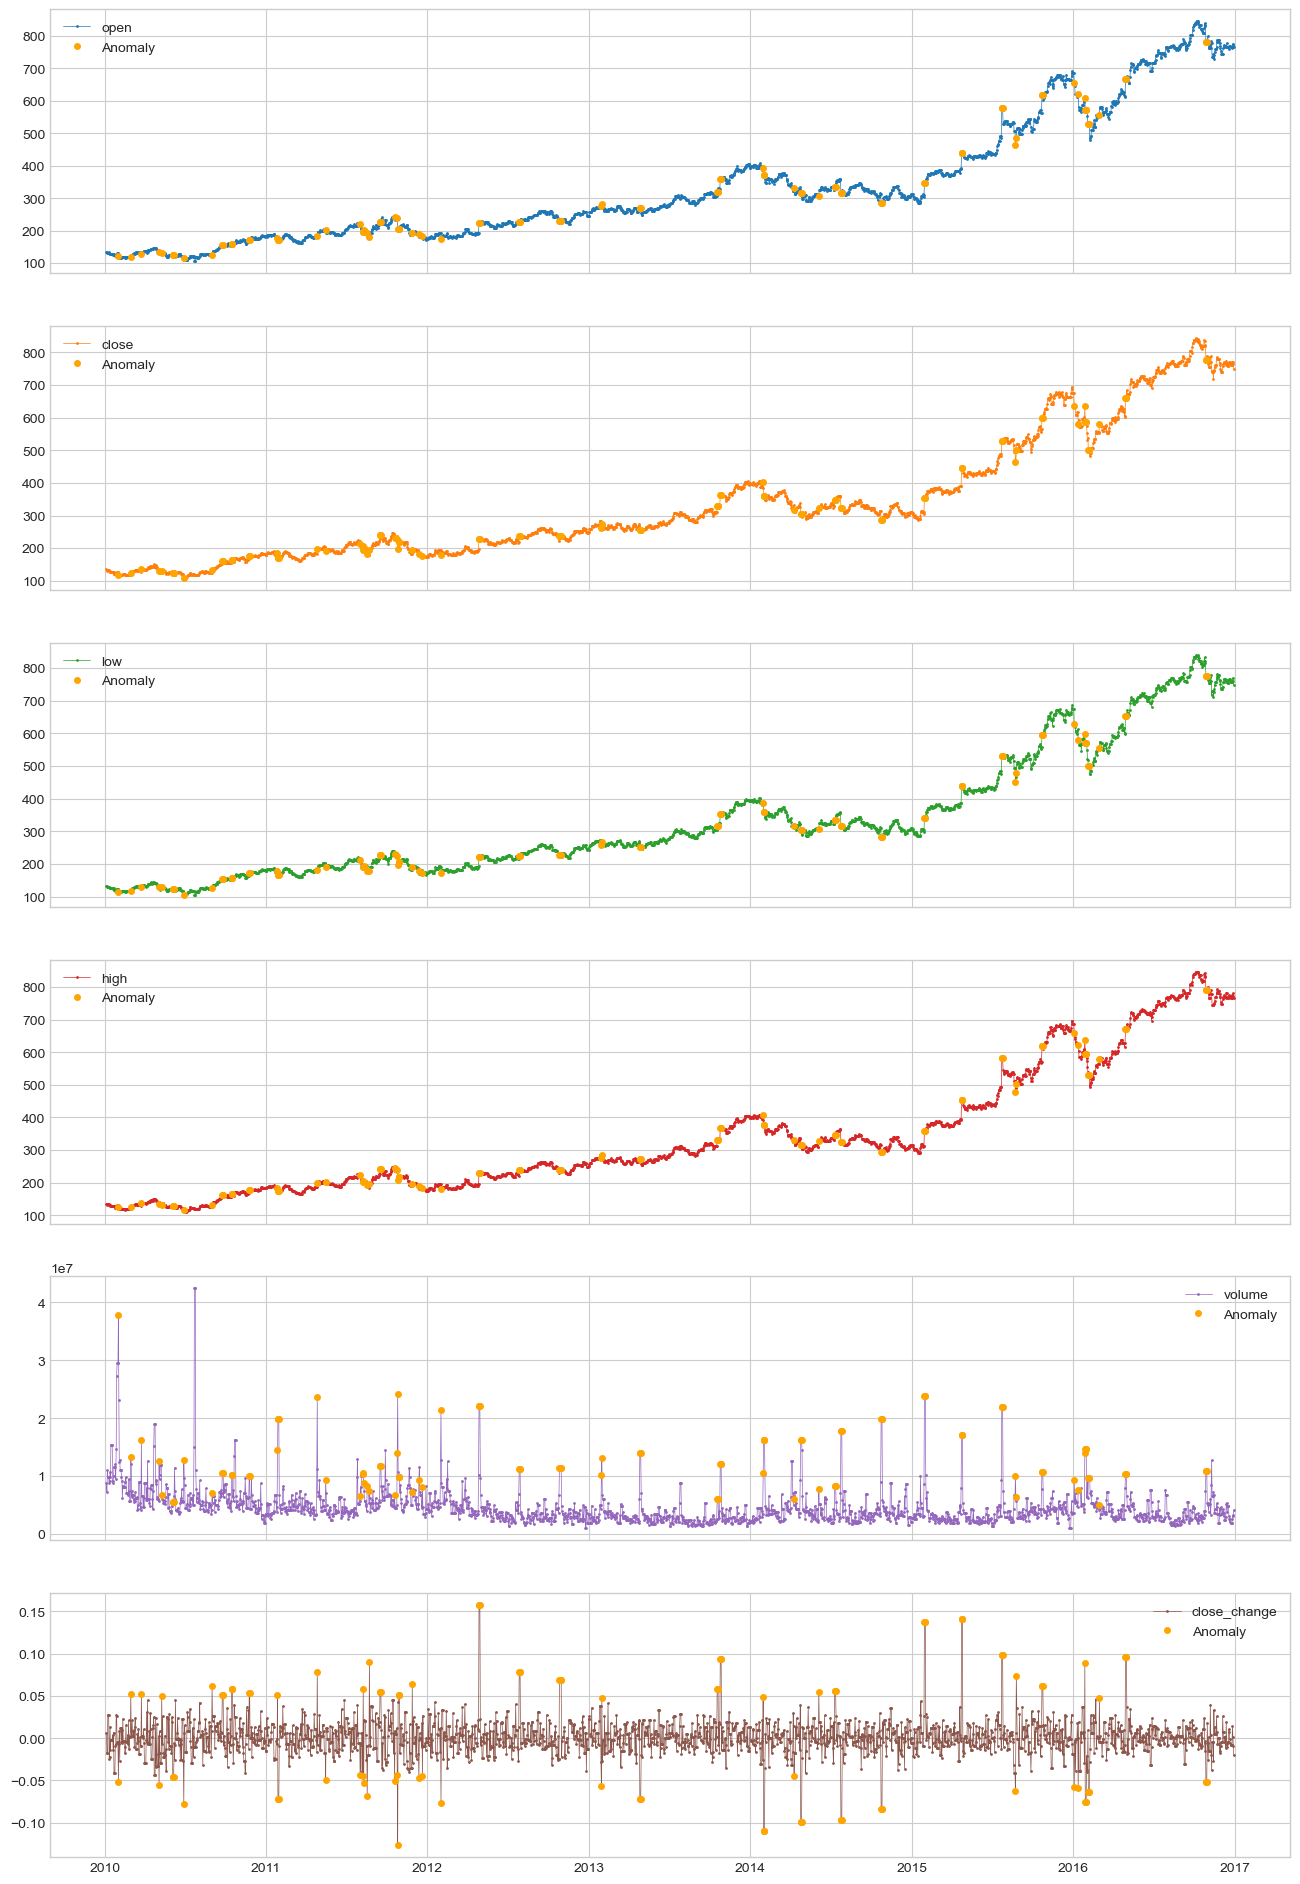

In [36]:
# Checking the threshhold anomaly of close_change
df_prices_sym =  threshhold_anomaly_detector(df_prices_sym, parameter= 'close_change', sd_threshhold=2)

High threshhold for close is set to 714.66
Low threshhold for close is set to -39.24
205 records are detected as close threshhold anomaly.
close_threshhold_anomaly column was added to dataframe.


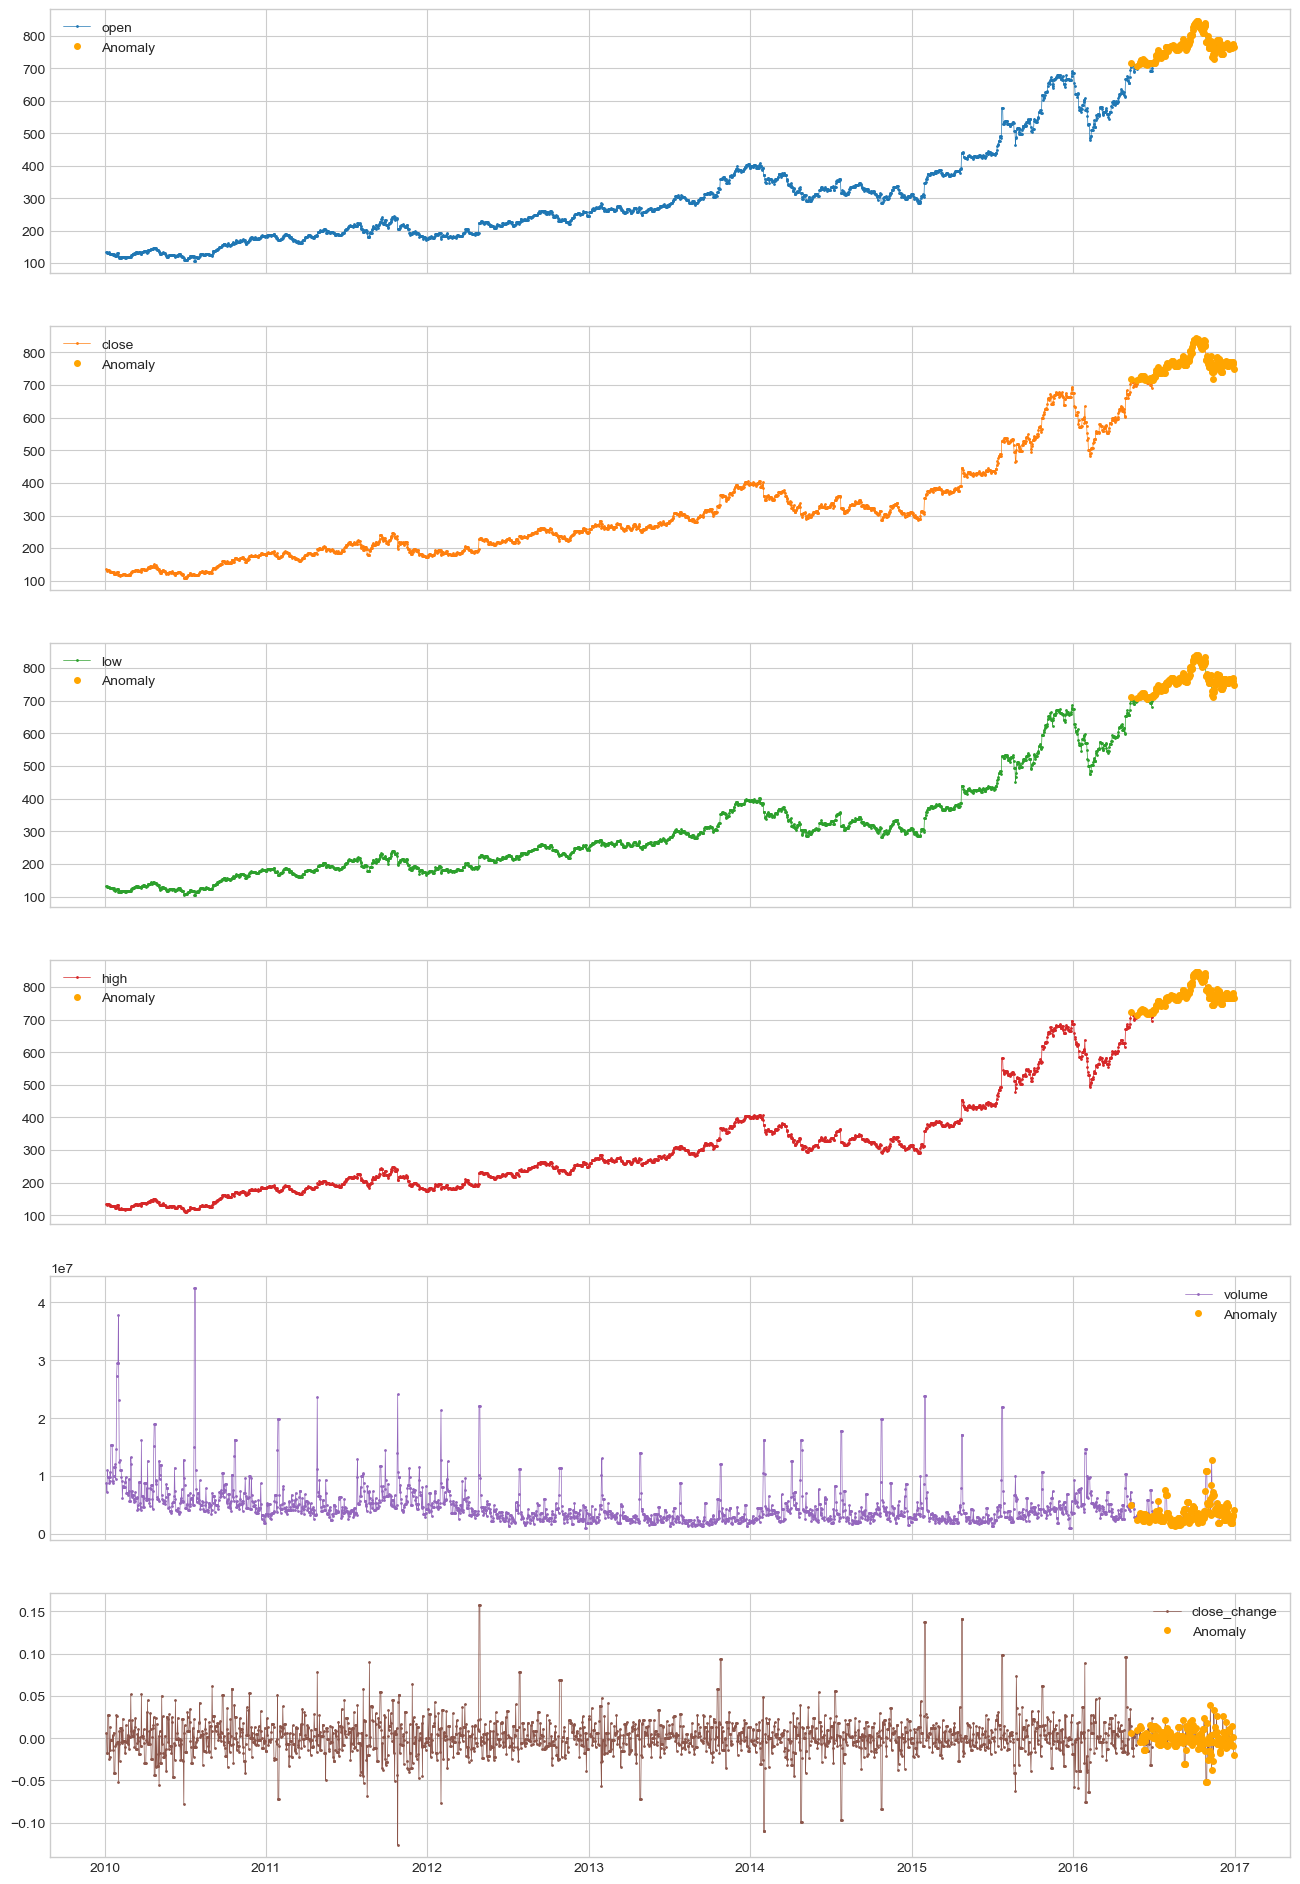

In [37]:
# Checking the threshhold anomaly of close
df_prices_sym =  threshhold_anomaly_detector(df_prices_sym, parameter= 'close', sd_threshhold=2)

    Observation:

* Since the close price has an increasing trend, the last few weeks were detected as anomalies while it is not corrected. 
* So this column (close_threshhold_anomaly) will be deleted.

In [38]:
# Deleting the close_threshhold_anomaly
df_prices_sym.drop('close_threshhold_anomaly',axis=1,inplace=True)

In [39]:
# Creating two series with anomalies (series) and without anomaly (series_wo_anomaly) for more anlysis
series_wo_anomaly = df_prices_sym[
    (df_prices_sym['volume_seasonal_anomaly'] == False) &
    (df_prices_sym['volume_threshhold_anomaly'] == False) & 
    (df_prices_sym['close_change_threshhold_anomaly'] == False)
]['close']

series = df_prices_sym['close']


    Observation:

* We considered anomaly when all these three columns are True so we provided a dataframe without anomalies.
* Now, there are two series :
    * one with anomalies (series)
    * the other is without anomalies (series_wo_anomaly) for feeding to ML model.

## 4. Data preparation

In [40]:
type(df_prices['date'][0])

str

    Observation:

The date value is a string instead of a date.
    
`df_prices['date'] = [datetime.strptime(x, "%Y-%m-%d") for x in df_prices['date']]`

In order to avoid a for a for loop, its better to use the following instruction:


In [41]:
# Convert date as datetime
df_prices['date'] = pd.to_datetime(df_prices['date'], format='%Y-%m-%d')
type(df_prices['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

    Observation:
* it should be interesting to create a new column with the year and the month of each observation

Store it to a new DateFrame stocksdt

`stocksdt = df_prices['date'].map(lambda x: [x.year, x.month])`

Add a new column to stocks with value for only Year (index 0)

`df_prices['year'] = stocksdt.map(lambda x: x[0])`

Add a new column to stocks with value for only Month (index 1)

`df_prices['month'] = stocksdt.map(lambda x: x[1])`

In order to avoid a more consumming lambda expression and mapping, it's better to use the following instruction:

In [42]:
# Create new column with year and month from its current date
df_prices['year'] = pd.DatetimeIndex(df_prices['date']).year
df_prices['month'] = pd.DatetimeIndex(df_prices['date']).month
df_prices

date symbol        open       close         low        high  \
0      2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000   
1      2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2      2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3      2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4      2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   
...           ...    ...         ...         ...         ...         ...   
851259 2016-12-30    ZBH  103.309998  103.199997  102.849998  103.930000   
851260 2016-12-30   ZION   43.070000   43.040001   42.689999   43.310001   
851261 2016-12-30    ZTS   53.639999   53.529999   53.270000   53.740002   
851262 2016-12-30    AIV   44.730000   45.450001   44.410000   45.590000   
851263 2016-12-30    FTV   54.200001   53.630001   53.389999   54.480000   

           volume  year  month  
0       2163600.0  2016      1  
1       2386400.0  2016      1  
2       2489500.0  2016      1  
3       2006300.0  2016      1  
4       1408600.0  2016      1  
...           ...   ...    ...  
851259   973800.0  2016     12  
851260  1938100.0  2016     12  
851261  1701200.0  2016     12  
851262  1380900.0  2016     12  
851263   705100.0  2016     12  

[851264 rows x 9 columns]

In [43]:
# merge two dataframes with respect 2 key factors (on=inner)
df_price_sec = df_prices.merge(df_securities, how="inner", left_on=["symbol"], right_on=["Ticker symbol"]).sort_values(by=['date'], ignore_index=True)
print(df_price_sec.shape)
df_price_sec

(851264, 17)


date symbol        open       close         low        high  \
0      2010-01-04     AN   19.459999   19.270000   19.209999   19.620001   
1      2010-01-04    PXD   49.380001   50.980000   49.380001   51.150002   
2      2010-01-04    MHK   48.270000   48.310001   47.950001   48.820000   
3      2010-01-04    IFF   41.509998   42.009998   41.500000   42.020000   
4      2010-01-04   CELG   56.639999   55.740002   55.330002   56.639999   
...           ...    ...         ...         ...         ...         ...   
851259 2016-12-30    FOX   27.500000   27.250000   27.080000   27.520000   
851260 2016-12-30   FOXA   28.290001   28.040001   27.920000   28.370001   
851261 2016-12-30    FRT  139.970001  142.110001  139.740005  142.809998   
851262 2016-12-30    FTI   35.599998   35.529999   35.389999   35.910000   
851263 2016-12-30    FTV   54.200001   53.630001   53.389999   54.480000   

           volume  year  month Ticker symbol  \
0       1650400.0  2010      1            AN   
1       1524100.0  2010      1           PXD   
2        497000.0  2010      1           MHK   
3        286000.0  2010      1           IFF   
4       4832000.0  2010      1          CELG   
...           ...   ...    ...           ...   
851259  2885000.0  2016     12           FOX   
851260  6161200.0  2016     12          FOXA   
851261   440000.0  2016     12           FRT   
851262  2039400.0  2016     12           FTI   
851263   705100.0  2016     12           FTV   

                                Security SEC filings             GICS Sector  \
0                         AutoNation Inc     reports  Consumer Discretionary   
1              Pioneer Natural Resources     reports                  Energy   
2                      Mohawk Industries     reports  Consumer Discretionary   
3              Intl Flavors & Fragrances     reports               Materials   
4                          Celgene Corp.     reports             Health Care   
...                                  ...         ...                     ...   
851259  Twenty-First Century Fox Class B     reports  Consumer Discretionary   
851260  Twenty-First Century Fox Class A     reports  Consumer Discretionary   
851261   Federal Realty Investment Trust     reports             Real Estate   
851262             FMC Technologies Inc.     reports                  Energy   
851263                      Fortive Corp     reports             Industrials   

                         GICS Sub Industry   Address of Headquarters  \
0                         Specialty Stores  Fort Lauderdale, Florida   
1       Oil & Gas Exploration & Production             Irving, Texas   
2                         Home Furnishings       Amsterdam, New York   
3                      Specialty Chemicals        New York, New York   
4                            Biotechnology        Summit, New Jersey   
...                                    ...                       ...   
851259                          Publishing        New York, New York   
851260                          Publishing        New York, New York   
851261                        Retail REITs       Rockville, Maryland   
851262      Oil & Gas Equipment & Services            Houston, Texas   
851263                Industrial Machinery       Everett, Washington   

       Date first added      CIK  
0                   NaN   350698  
1            2008-09-24  1038357  
2            2013-12-23   851968  
3            1976-03-31    51253  
4                   NaN   816284  
...                 ...      ...  
851259       2015-09-18  1308161  
851260       2013-07-01  1308161  
851261       2016-02-01    34903  
851262       2009-06-05  1135152  
851263       2016-07-01  1659166  

[851264 rows x 17 columns]

In [44]:
# number of unique values per column
df_price_sec['symbol'].nunique() 

501

In [45]:
df_price_sec['Ticker symbol'].nunique() 

501

    Observation:

501 unique stock options from the dataframe `df_prices` are preserved with regard the 505 unique stock options from the dataframe `df_securities` (4 Ticker symbols are discarded)

In [46]:
# select only several variables from dataframe
df = df_price_sec[['date', 'symbol', 'open', 'close', 'low', 'high', 'volume', 'year', 'month', 'GICS Sector']]
df

date symbol        open       close         low        high  \
0      2010-01-04     AN   19.459999   19.270000   19.209999   19.620001   
1      2010-01-04    PXD   49.380001   50.980000   49.380001   51.150002   
2      2010-01-04    MHK   48.270000   48.310001   47.950001   48.820000   
3      2010-01-04    IFF   41.509998   42.009998   41.500000   42.020000   
4      2010-01-04   CELG   56.639999   55.740002   55.330002   56.639999   
...           ...    ...         ...         ...         ...         ...   
851259 2016-12-30    FOX   27.500000   27.250000   27.080000   27.520000   
851260 2016-12-30   FOXA   28.290001   28.040001   27.920000   28.370001   
851261 2016-12-30    FRT  139.970001  142.110001  139.740005  142.809998   
851262 2016-12-30    FTI   35.599998   35.529999   35.389999   35.910000   
851263 2016-12-30    FTV   54.200001   53.630001   53.389999   54.480000   

           volume  year  month             GICS Sector  
0       1650400.0  2010      1  Consumer Discretionary  
1       1524100.0  2010      1                  Energy  
2        497000.0  2010      1  Consumer Discretionary  
3        286000.0  2010      1               Materials  
4       4832000.0  2010      1             Health Care  
...           ...   ...    ...                     ...  
851259  2885000.0  2016     12  Consumer Discretionary  
851260  6161200.0  2016     12  Consumer Discretionary  
851261   440000.0  2016     12             Real Estate  
851262  2039400.0  2016     12                  Energy  
851263   705100.0  2016     12             Industrials  

[851264 rows x 10 columns]

In [47]:
# check the number of observations per symbol (company)
df.groupby(['symbol']).agg(len)

date  open  close   low  high  volume  year  month  GICS Sector
symbol                                                                 
A       1762  1762   1762  1762  1762    1762  1762   1762         1762
AAL     1762  1762   1762  1762  1762    1762  1762   1762         1762
AAP     1762  1762   1762  1762  1762    1762  1762   1762         1762
AAPL    1762  1762   1762  1762  1762    1762  1762   1762         1762
ABBV    1008  1008   1008  1008  1008    1008  1008   1008         1008
...      ...   ...    ...   ...   ...     ...   ...    ...          ...
YHOO    1762  1762   1762  1762  1762    1762  1762   1762         1762
YUM     1762  1762   1762  1762  1762    1762  1762   1762         1762
ZBH     1762  1762   1762  1762  1762    1762  1762   1762         1762
ZION    1762  1762   1762  1762  1762    1762  1762   1762         1762
ZTS      987   987    987   987   987     987   987    987          987

[501 rows x 9 columns]

    Observation:
Each stock option (symbol) don't have the same number of observations.

In [48]:
# Statistic description open values by sector
sectors = df.groupby(['GICS Sector'])['close']
sectors.describe()

count       mean         std        min  \
GICS Sector                                                               
Consumer Discretionary       143783.0  80.820500  128.632652   3.540000   
Consumer Staples              61182.0  61.748178   28.290475  12.240000   
Energy                        61170.0  61.700904   30.772335   1.590000   
Financials                   103959.0  55.496313   50.629914   1.420000   
Health Care                   99898.0  89.147720   80.348716   4.970000   
Industrials                  115950.0  69.138038   43.873434   4.000000   
Information Technology       113484.0  80.002773  130.171098   4.330000   
Materials                     42594.0  74.992211   49.012843   3.740000   
Real Estate                   51098.0  72.488134   54.535782   8.940006   
Telecommunications Services    8810.0  29.183503   16.076585   0.860000   
Utilities                     49336.0  44.986152   20.497990   8.540000   

                                   25%        50%         75%          max  
GICS Sector                                                                 
Consumer Discretionary       32.720001  52.299999   78.080002  1578.130005  
Consumer Staples             39.220001  58.764999   79.180000   171.240005  
Energy                       37.980000  58.419998   80.769997   233.070007  
Financials                   26.110001  41.889999   64.860001   398.450012  
Health Care                  44.880001  67.199997  102.620003   724.830017  
Industrials                  39.840000  59.575001   87.739998   291.809998  
Information Technology       27.770000  44.750000   71.220001  1220.172036  
Materials                    44.200001  61.340000   92.089996   321.819992  
Real Estate                  31.889999  58.785000   95.050003   389.450012  
Telecommunications Services   9.502500  33.625000   40.349998    57.200001  
Utilities                    30.980000  42.180000   56.340000   130.889999

In [49]:
# Statistic description open values by sector
sectors = df.groupby(['GICS Sector'])['volume']
sectors.describe()

count          mean           std       min  \
GICS Sector                                                                   
Consumer Discretionary       143783.0  4.509139e+06  8.101091e+06       0.0   
Consumer Staples              61182.0  4.507772e+06  4.802656e+06  109800.0   
Energy                        61170.0  5.918965e+06  6.831543e+06  148200.0   
Financials                   103959.0  7.749111e+06  2.283290e+07       0.0   
Health Care                   99898.0  4.069756e+06  7.196919e+06       0.0   
Industrials                  115950.0  3.534210e+06  7.564666e+06   55700.0   
Information Technology       113484.0  1.035927e+07  1.951891e+07    7900.0   
Materials                     42594.0  3.747326e+06  6.073505e+06     100.0   
Real Estate                   51098.0  2.073531e+06  2.306404e+06   64600.0   
Telecommunications Services    8810.0  1.378897e+07  1.534696e+07  154400.0   
Utilities                     49336.0  2.815280e+06  2.377025e+06  177700.0   

                                   25%         50%         75%          max  
GICS Sector                                                                  
Consumer Discretionary       1196400.0   2532800.0   5054400.0  480879500.0  
Consumer Staples             1473400.0   3020300.0   5807000.0  123735700.0  
Energy                       2264900.0   4034800.0   7185125.0  273996600.0  
Financials                   1456900.0   2847300.0   5994750.0  859643400.0  
Health Care                   893400.0   1815500.0   4414175.0  284468100.0  
Industrials                   950200.0   1795400.0   3567875.0  431332600.0  
Information Technology       1810600.0   3746200.0  10152975.0  560040200.0  
Materials                     927425.0   1788600.0   4206025.0  153828000.0  
Real Estate                   778300.0   1429700.0   2549250.0  116835700.0  
Telecommunications Services  4288775.0  10759500.0  19357450.0  616620500.0  
Utilities                    1315075.0   2210950.0   3586525.0  101654600.0

    Observation:
* Important quantity of observations (count) in sectors (Consumer Discretionary, Financials, Health Care, Industrials, Information Technology).
* A significant dispersion (std) of close stock option in the sectors (Consumer Discretionary, Information Technology).
* Important volume (mean) of stock option traded in sectors (Information Technology, Telecommunications Services).
* Sectors (Consumer Discretionary, Financials, Health Care) with 0 volum (min): This is strange...

In [305]:
# function which return normalized values
#def df_norm(df):
#	df_norm = df.copy()
#	df_norm.open = ( df.open- df.open.mean() ) / ( df.open.std() ) 
#	df_norm.close = ( df.close - df.close.mean() ) / ( df.close.std() ) 
#	df_norm.low = ( df.low - df.low.mean() ) / ( df.low.std() ) 
#	df_norm.high = ( df.high - df.high.mean() ) / ( df.high.std() ) 
#	df_norm.volume = ( df.volume - df.volume.mean() ) / ( df.volume.std() ) 
#	return (df_norm)

    Observation
* The normalization will permit to avoid the risk of distorsion between different units (close in dollar, volume of stock options exchanged).
* The normalization above is not used because the function df_norm(df) should normalize the entire column observations including all stock options ('symbol') of the dataframe.
* The decision made is to keep the observations for each sector as there are.

## 5. Graphics

## 5.1 Overview of stock options by sector

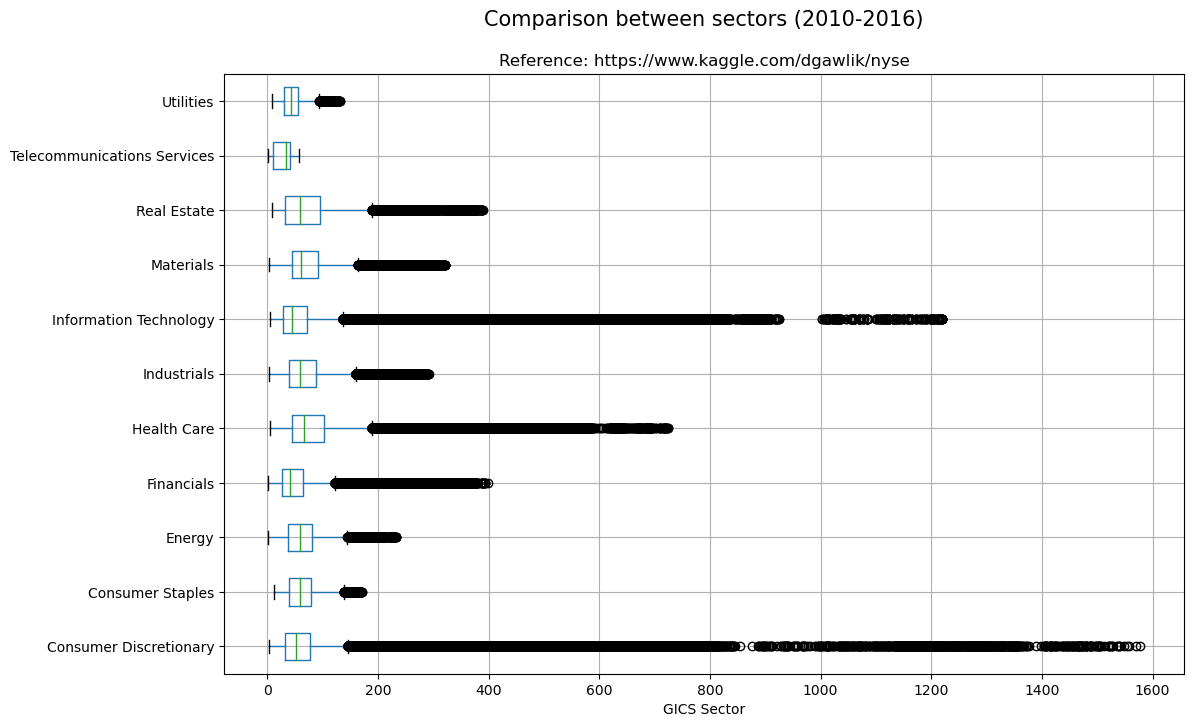

In [306]:
# boxplot for assessment of dispersion of stock options close value per sector during 2010-2016
df.boxplot(column="close", by="GICS Sector", vert= False)
plt.suptitle("Comparison between sectors (2010-2016)", fontsize=15)
plt.title("Reference: https://www.kaggle.com/dgawlik/nyse")
plt.show()

    Observation:
1. The stock options in the sector of Telecommunications Services are without outlier (anomaly).
2. The other sectors have outliers
3. Sectors (Real Estate, Health Care) have their most extended values (50% and max)
4. On a daily basis:
    * with low risk, very limited profits could be captured in the sector Telecommunications Services (no outliers):
    * with middle risk, most profits could be captured in the sectors (see maximum limit):
        * Real Estate, 
        * Health Care.
    * with high risk, the most significant profits are in the sectors (see outliers):
        * Consumer Discretionary, 
        * Information technology, 
        * Health Care.


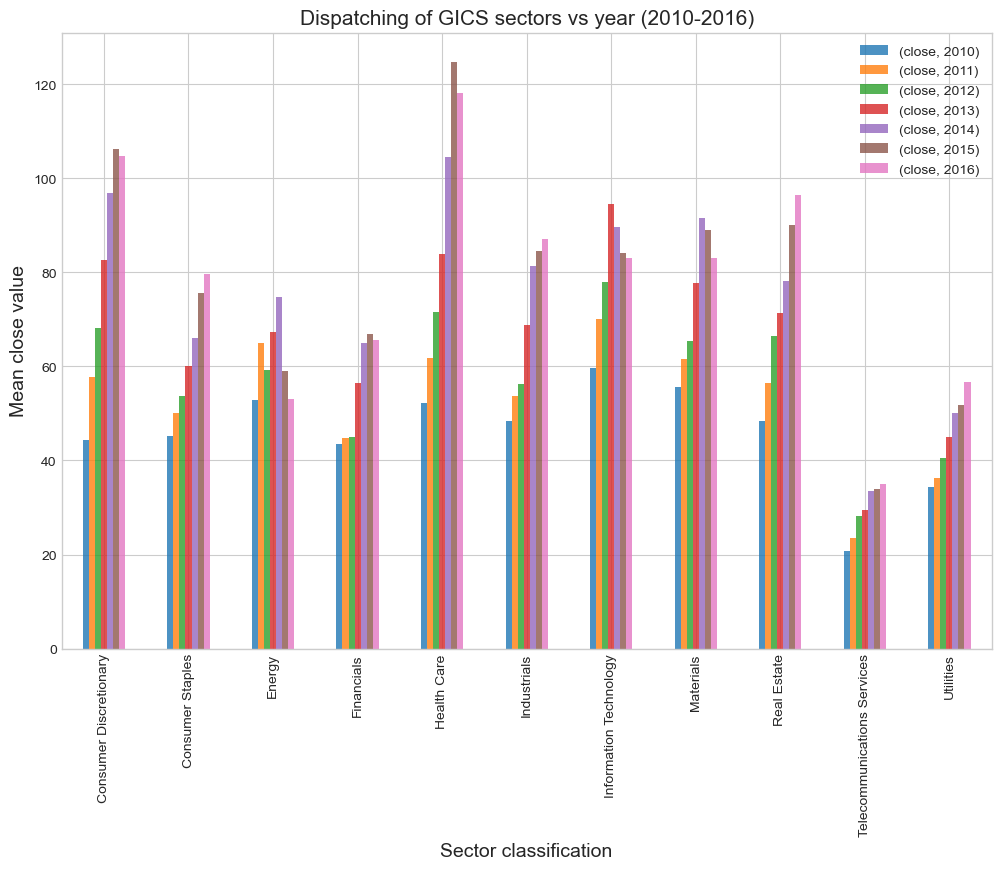

In [50]:
# plot the sectors by year with regard the mean of close stock option value
df_close = df[['date', 'year', 'GICS Sector', 'symbol', 'close']] 
df_close.groupby(['year', 'GICS Sector']).mean().unstack('year').plot(kind='bar', alpha=0.8, stacked=False)
plt.title('Dispatching of GICS sectors vs year (2010-2016)',fontsize=15)
plt.xlabel('Sector classification', fontsize=14)
plt.ylabel('Mean close value', fontsize=14)
plt.legend(loc="best") 
plt.show()

    Observation:
The stock options (closing value) that have very good progression over the long term (years) are the sectors: 
* Consumer Discretionary, 
* Consumer Staples, 
* Healthcare (except in 2016), 
* Industrials (with a certain variability)
* Real Estate.

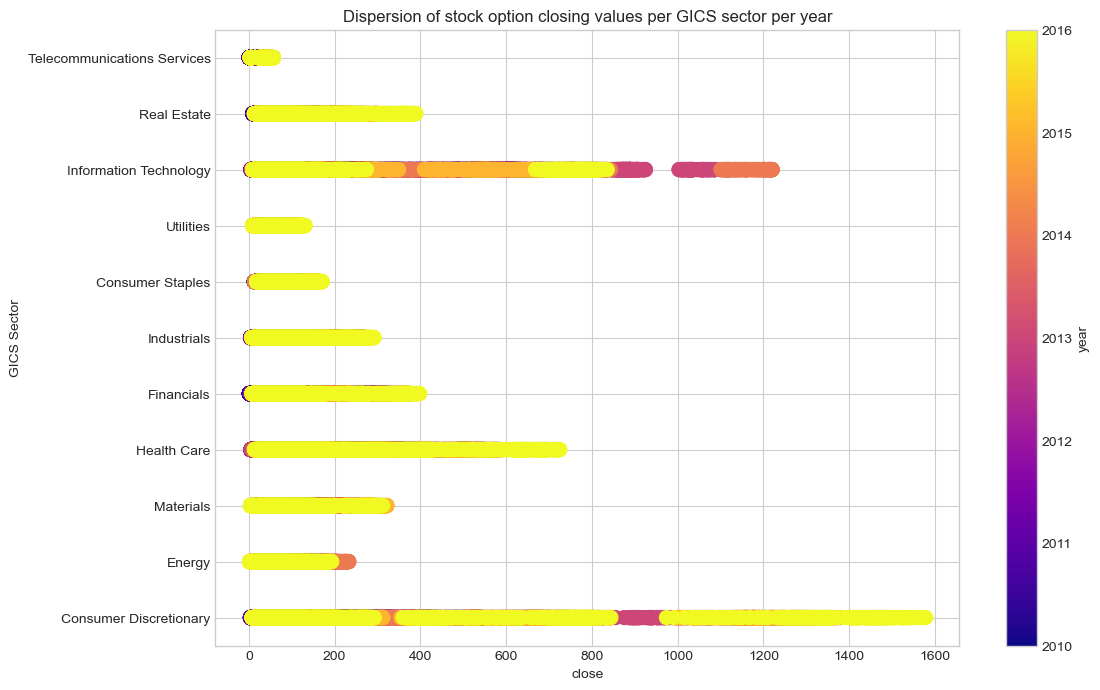

In [51]:
# graphic with 3 variables
df_close.plot(kind = "scatter", y="GICS Sector", x="close", c="year", s=100, cmap=plt.get_cmap("plasma"), marker='o')
plt.title('Dispersion of stock option closing values per GICS sector per year')
plt.show()

    Observation:
* The stock options in each GICS sector have in a large dispersion in 2016 (yellow) of their stock option closing values.
* The sector Information technology decreased its stock option close values in 2016 (yellow).


## 5.2. Focus on "Consumer Discretionary" GICS sector (large number of outliers)

In [52]:
# function which select one specific GICS sector from dataframe df and display a histogram in order to show the distribution of the selected sector
def hist_sector(df, sector):
    index_CD = np.where(df['GICS Sector'] == sector)
    df_CD = df.iloc[index_CD]
    print(df_CD.shape[0])
    sbn.histplot(df_CD['close'], bins=100, kde=True)
    plt.title("Distribution of " + sector + " GICS sector")
    

143783


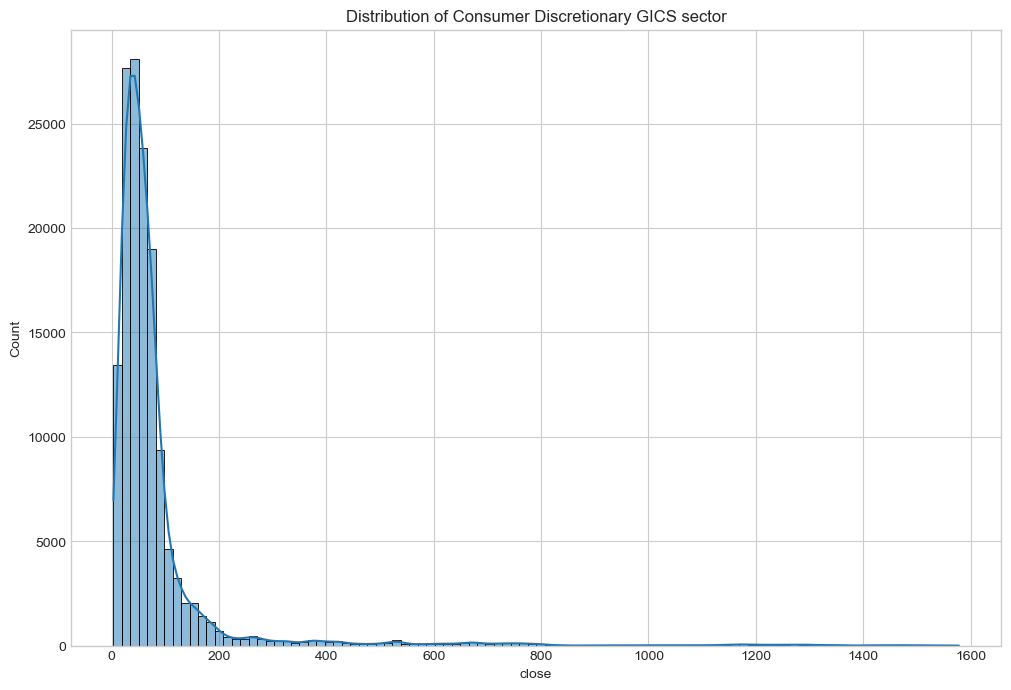

In [53]:
hist_sector(df=df, sector='Consumer Discretionary')

    Observation:
* With 143783 observations, the Consumer Discretionary sector looks like a log normal distribution.
* This should be confirmed if the log distribution is gaussian.

/var/folders/wj/2t2894gx1r17grsnfcv7knq80000gn/T/ipykernel_33107/481140967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['log_close'] = np.log(df_temp['close'])


Text(0.5, 1.0, 'Log distribution of Consumer Discretionary')

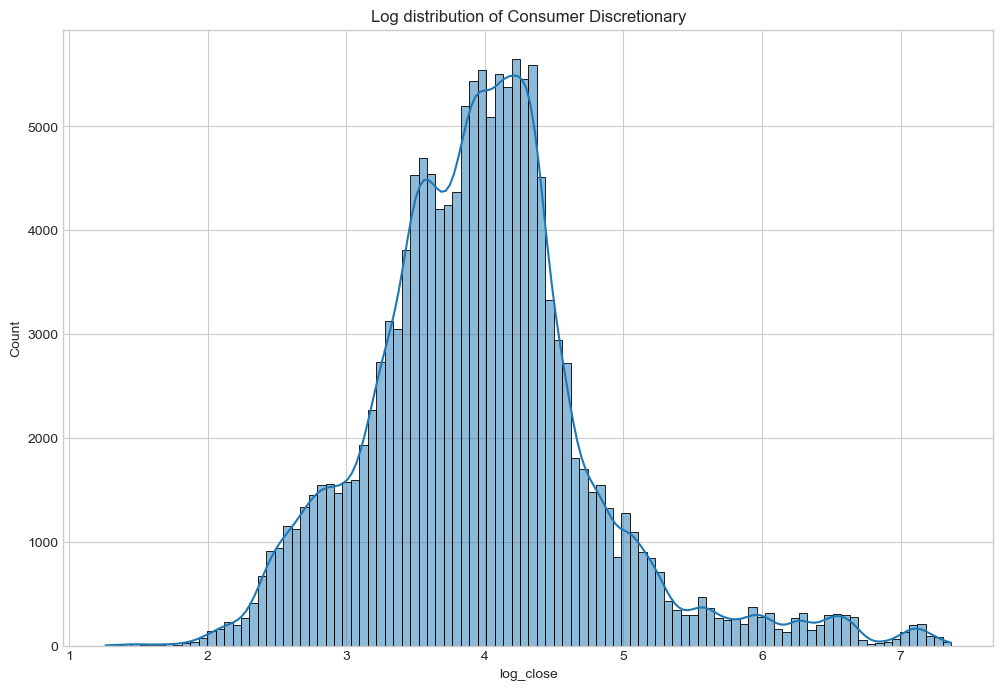

In [54]:
df_temp = df.iloc[np.where(df['GICS Sector'] == 'Consumer Discretionary')]
df_temp['log_close'] = np.log(df_temp['close'])
sbn.histplot(df_temp['log_close'], bins=100, kde=True)
plt.title("Log distribution of Consumer Discretionary")

    Observation:
* With 143783 observations, the log distribution of the Consumer Discretionary sector is not a formal normal distribution (see head and right tail of the shape).
* In this condition, the Consumer Discretionary sector distribution is not a log normal distribution.

In [55]:
# function which plot close values (min, mean, max) of stock options from one GICS sector and one year from dataframe df
def plot_sector_year(df, sector, year):
    df = df.loc[np.where(df['GICS Sector'] == sector)]
    df = df.loc[df['year'] == year]
    df_min = df.groupby(['date']).min()
    df_mean = df.groupby(['date']).mean()
    df_max = df.groupby(['date']).max()
    df_min['close'].plot(x='date', y='close', style='b-')
    df_mean['close'].plot(x='date', y='close', style='k-')
    df_max['close'].plot(x='date', y='close', style='r-')
    year = str(year)
    plt.title('Evolution of stock option for ' + sector + ' during ' + year)
    plt.xlabel('Year')
    plt.ylabel('Stock option value (close)')
    plt.legend(['Min', 'Mean', 'Max'], loc='best')
    plt.show()

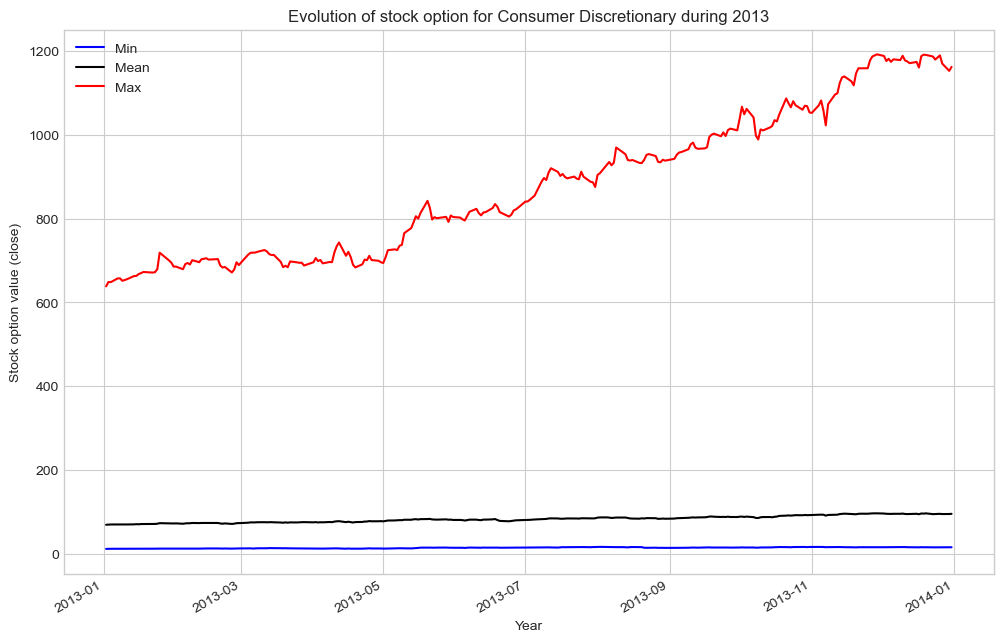

In [56]:
plot_sector_year(df=df_close, sector='Consumer Discretionary', year=2013)

    Observation:
Overall growth in the value of consumer discretionary stock options in 2013 is driven by specific performing companies (see Mean and Max curves)

### Do we have a correlation between close and volume ?

    Observation:
in order to compare 2 variables of different units, we need to normalize these variables.
We will not normalize for the reason explained before.

In [57]:
# function which select one specific GICS sector from dataframe data
def sector(df, sector):
    return (df.loc[np.where(df['GICS Sector'] == sector)])

In [58]:
df_close_vol = df[['date', 'year', 'GICS Sector', 'volume','close']] 
sector(df=df_close_vol, sector='Consumer Discretionary')

date  year             GICS Sector     volume      close
0      2010-01-04  2010  Consumer Discretionary  1650400.0  19.270000
2      2010-01-04  2010  Consumer Discretionary   497000.0  48.310001
14     2010-01-04  2010  Consumer Discretionary  2228100.0  35.000000
34     2010-01-04  2010  Consumer Discretionary  4444300.0   7.530000
37     2010-01-04  2010  Consumer Discretionary  3059400.0  48.170002
...           ...   ...                     ...        ...        ...
851237 2016-12-30  2016  Consumer Discretionary   739200.0  48.490002
851239 2016-12-30  2016  Consumer Discretionary  1929400.0  30.870001
851253 2016-12-30  2016  Consumer Discretionary  1050500.0  70.889999
851259 2016-12-30  2016  Consumer Discretionary  2885000.0  27.250000
851260 2016-12-30  2016  Consumer Discretionary  6161200.0  28.040001

[143783 rows x 5 columns]

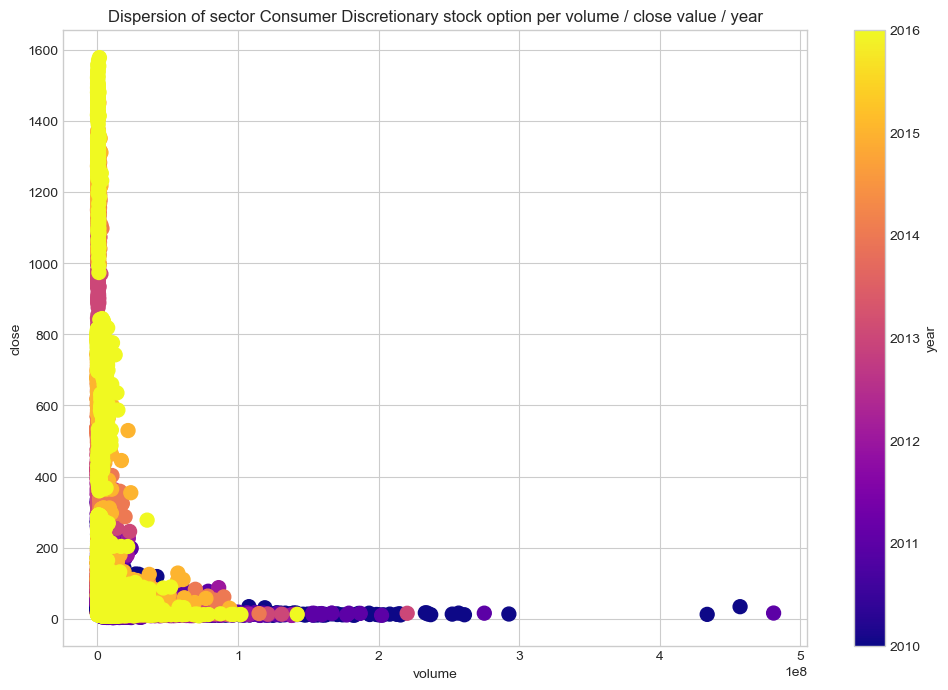

In [59]:
# graphic with 3 variables
sector(df=df_close_vol, sector='Consumer Discretionary').plot(kind="scatter", x="volume", y="close", c="year", s=100, cmap=plt.get_cmap("plasma"), marker='o')
plt.title('Dispersion of sector Consumer Discretionary stock option per volume / close value / year')
plt.show()

    Observation:
* The highest close values of stock options in 2016 are correlated with relative low volume traded.
* The largest volumes traded in the previous years are correlated with low close values of stock options.


In [61]:
cons_close = sector(df=df_close_vol, sector='Consumer Discretionary')['close']
cons_volume = sector(df=df_close_vol, sector='Consumer Discretionary')['volume']

ss.pearsonr(cons_close, cons_volume)

(-0.1411617325051652, 0.0)

    Observation:
* p-value = 0.0 < 0.5 => the pearson correlation is statistically significant between the two variables
* The correlation for the sector Consumer Discretionary is very low and negative (-0.14)

    `Conclusion`: 
* There is no real correlation between  between close price and volume for the sector Consumer Discretionary
* The correlation between close price and volume for a specific company should be done only with the data of this company.

## 5.3. Focus on "Telecommunications Services" GICS sector (no outlier)

8810


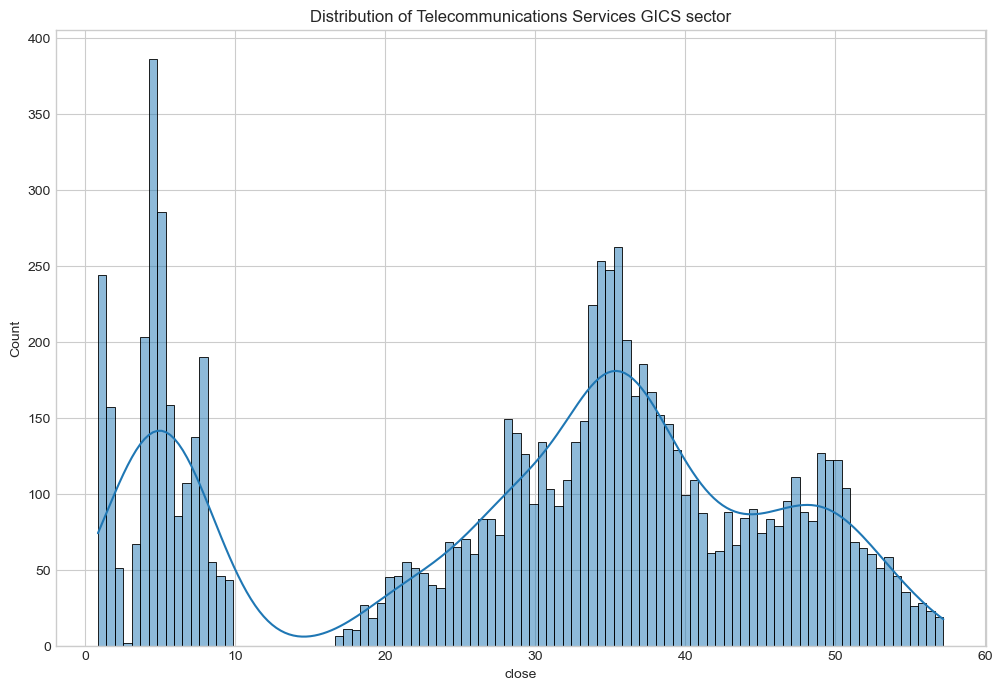

In [62]:
hist_sector(df=df, sector='Telecommunications Services')

    Observation:
* With 8810 observations, the Telecommunications Services sector looks like a multimodal distribution.
* They is no any close price values between around 10 and 16. This is strange...


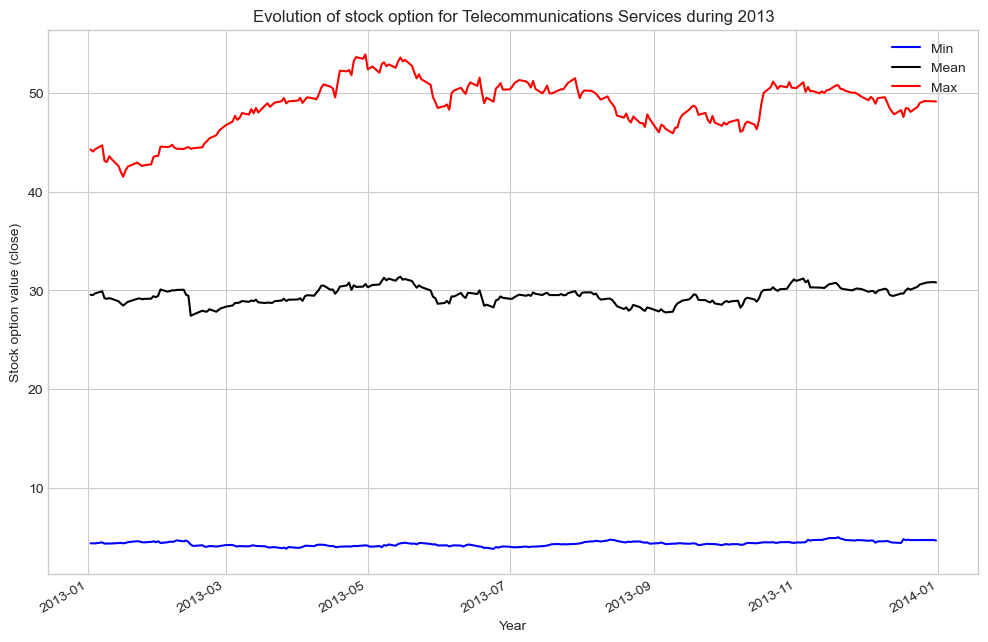

In [63]:
plot_sector_year(df=df_close, sector='Telecommunications Services', year=2013)

    Observation:
Despite a disparity in the values of sector Telecommunications Services (see Min and Max), the average stabilizes at a certain value.

### Do we have a correlation between close and volume ?

In [64]:
sector(df=df_close_vol, sector='Telecommunications Services')

date  year                  GICS Sector      volume      close
157    2010-01-04  2010  Telecommunications Services  11418500.0   1.610000
160    2010-01-04  2010  Telecommunications Services  16176600.0  33.279869
177    2010-01-04  2010  Telecommunications Services   2068100.0  36.660000
179    2010-01-04  2010  Telecommunications Services  29136600.0  28.580000
251    2010-01-04  2010  Telecommunications Services   4030400.0   7.960000
...           ...   ...                          ...         ...        ...
850779 2016-12-30  2016  Telecommunications Services  16674000.0  42.529999
850931 2016-12-30  2016  Telecommunications Services   1679200.0  56.360001
850992 2016-12-30  2016  Telecommunications Services   6939000.0  23.780001
851161 2016-12-30  2016  Telecommunications Services  12440800.0  53.380001
851241 2016-12-30  2016  Telecommunications Services  20394600.0   3.380000

[8810 rows x 5 columns]

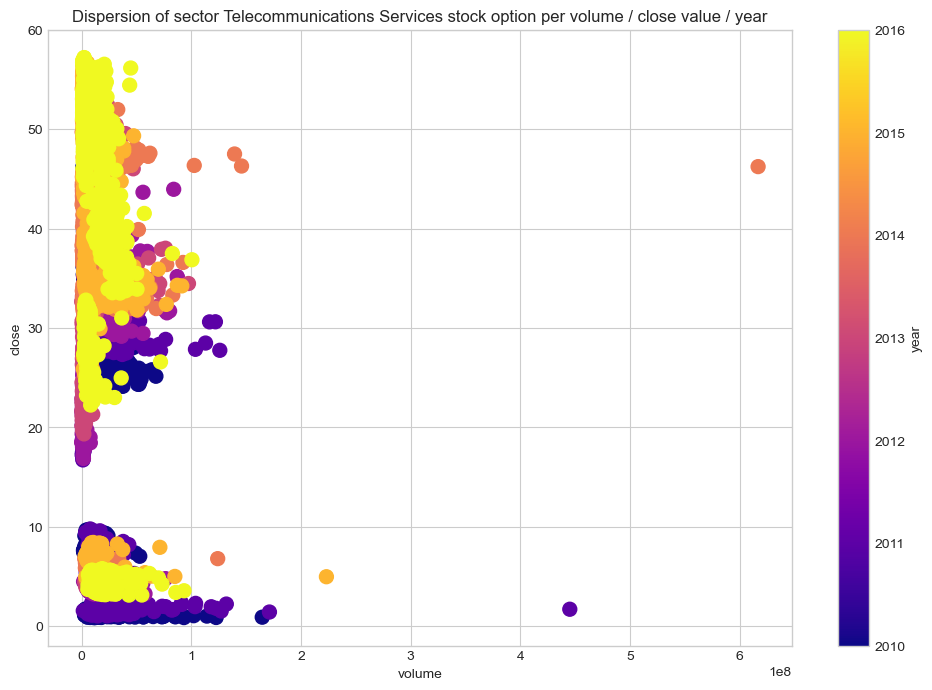

In [65]:
# graphic with 3 variables
sector(df=df_close_vol, sector='Telecommunications Services').plot(kind="scatter", x="volume", y="close", c="year", s=100, cmap=plt.get_cmap("plasma"), marker='o')
plt.title('Dispersion of sector Telecommunications Services stock option per volume / close value / year')
plt.show()

    Observation:
* The majority of values are concentrated to relative low volumes.
* In 2016 the close stock option values are very dispersed with regard relative low volume


In [66]:
tel_close = sector(df=df_close_vol, sector='Telecommunications Services')['close']
tel_volume = sector(df=df_close_vol, sector='Telecommunications Services')['volume']

from scipy.stats.stats import pearsonr

pearsonr(tel_close, tel_volume)

(-0.09543637263978254, 2.781606604681422e-19)

    Observation:
* p-value ≈ 0 < 0.5 => the pearson correlation is statistically significant between the two variables
* The correlation for the sector Telecommunications Services is very low and negative (-0.09)

    `Conclusion`: 
* There is no real correlation between  between close price and volume for the sector Telecommunications Services
* The correlation between close price and volume for a specific company should be done only with the data of this company.

In [67]:
df_sector = pd.get_dummies(df, columns = ['GICS Sector'])
df_sector

date symbol        open       close         low        high  \
0      2010-01-04     AN   19.459999   19.270000   19.209999   19.620001   
1      2010-01-04    PXD   49.380001   50.980000   49.380001   51.150002   
2      2010-01-04    MHK   48.270000   48.310001   47.950001   48.820000   
3      2010-01-04    IFF   41.509998   42.009998   41.500000   42.020000   
4      2010-01-04   CELG   56.639999   55.740002   55.330002   56.639999   
...           ...    ...         ...         ...         ...         ...   
851259 2016-12-30    FOX   27.500000   27.250000   27.080000   27.520000   
851260 2016-12-30   FOXA   28.290001   28.040001   27.920000   28.370001   
851261 2016-12-30    FRT  139.970001  142.110001  139.740005  142.809998   
851262 2016-12-30    FTI   35.599998   35.529999   35.389999   35.910000   
851263 2016-12-30    FTV   54.200001   53.630001   53.389999   54.480000   

           volume  year  month  GICS Sector_Consumer Discretionary  \
0       1650400.0  2010      1                                   1   
1       1524100.0  2010      1                                   0   
2        497000.0  2010      1                                   1   
3        286000.0  2010      1                                   0   
4       4832000.0  2010      1                                   0   
...           ...   ...    ...                                 ...   
851259  2885000.0  2016     12                                   1   
851260  6161200.0  2016     12                                   1   
851261   440000.0  2016     12                                   0   
851262  2039400.0  2016     12                                   0   
851263   705100.0  2016     12                                   0   

        GICS Sector_Consumer Staples  GICS Sector_Energy  \
0                                  0                   0   
1                                  0                   1   
2                                  0                   0   
3                                  0                   0   
4                                  0                   0   
...                              ...                 ...   
851259                             0                   0   
851260                             0                   0   
851261                             0                   0   
851262                             0                   1   
851263                             0                   0   

        GICS Sector_Financials  GICS Sector_Health Care  \
0                            0                        0   
1                            0                        0   
2                            0                        0   
3                            0                        0   
4                            0                        1   
...                        ...                      ...   
851259                       0                        0   
851260                       0                        0   
851261                       0                        0   
851262                       0                        0   
851263                       0                        0   

        GICS Sector_Industrials  GICS Sector_Information Technology  \
0                             0                                   0   
1                             0                                   0   
2                             0                                   0   
3                             0                                   0   
4                             0                                   0   
...                         ...                                 ...   
851259                        0                                   0   
851260                        0                                   0   
851261                        0                                   0   
851262                        0                                   0   
851263                        1                 

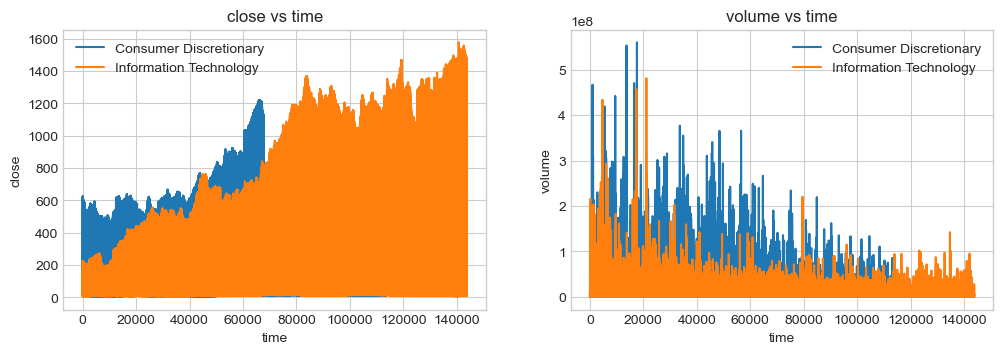

In [68]:
info = ['close', 'volume']
for i in range(2) :
    plt.subplot(2,2,i+1)
    
    plt.plot(df_sector[df_sector['GICS Sector_Information Technology']== 1][info[i]].values)
    plt.plot(df_sector[df_sector['GICS Sector_Consumer Discretionary'] == 1][info[i]].values)
  
    plt.xlabel('time' )
    plt.ylabel(info[i])
    plt.legend(['Consumer Discretionary','Information Technology'])
    plt.title(info[i] + ' vs time')
plt.show()

    Observation:
We can see the comparison between this 2 sectors:
* At the first half part of the period (2010-2013):
    * Consumer Discretionary (higher close values and higher volume) vs Information technology (lower close values and lower volume)
* At the second half part of the period (2013-2016):
    * The contrary (except at the end of the period: a trend of more volume for Information Technology)

## 5.4. Focus on volume

In [69]:
# select only 3 variables from dataframe
data_vol = df[['year', 'GICS Sector', 'volume']] 
# get volume by sector
data_vol.groupby(['GICS Sector'])['volume'].sum()

GICS Sector
Consumer Discretionary         6.483375e+11
Consumer Staples               2.757945e+11
Energy                         3.620631e+11
Financials                     8.055899e+11
Health Care                    4.065605e+11
Industrials                    4.097916e+11
Information Technology         1.175611e+12
Materials                      1.596136e+11
Real Estate                    1.059533e+11
Telecommunications Services    1.214808e+11
Utilities                      1.388947e+11
Name: volume, dtype: float64

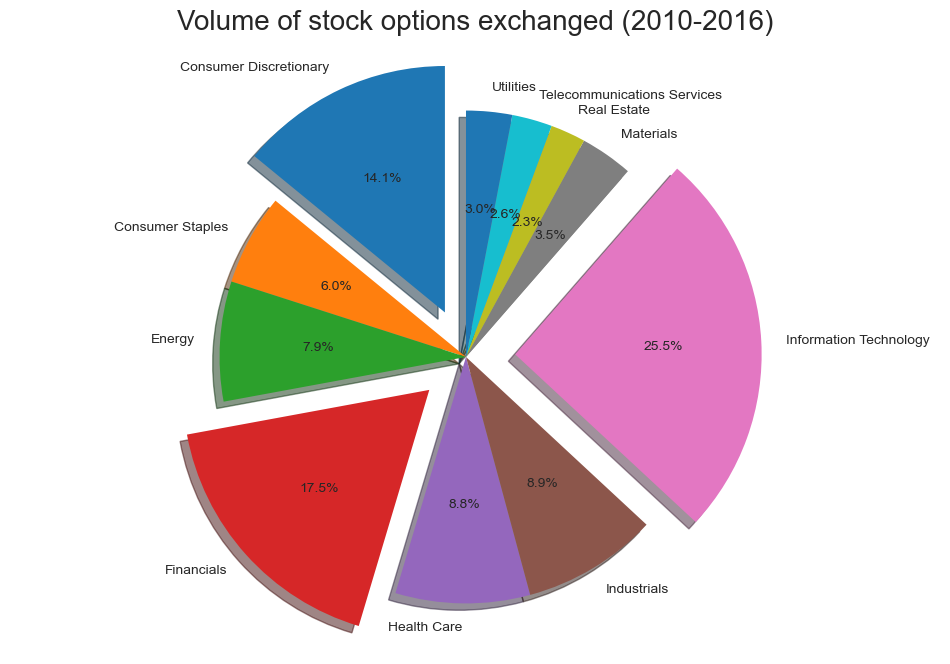

In [70]:
# pie chart for first priority worrying subject
# explode -> extract several of the parts of the diagram to highlight them
# autopct -> display the value of the proportion of each modality in each part of the diagram.
# shadow=true -> display a cast shadow
# startangle -> angle that marks the start of the diagram
explode = (0.2, 0, 0, 0.2, 0, 0, 0.2, 0, 0, 0, 0) 
data_vol.groupby(['GICS Sector'])['volume'].sum().plot(kind="pie", explode=explode, autopct='%.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Volume of stock options exchanged (2010-2016)', fontsize=20)
plt.ylabel('')
plt.show()

    Observation:
The largest volumes of stock options traded during the period (2010-2016) are the sectors: 
* Information Technology, 
* Financials, 
* Consumers Discretionary.


## 6. Prediction

In order to have a coherent "group" work, we decided to focus on `Amazon` stock price :
* `Amazon` belongs to sector Consumer Discretionary with highest number of outliers (anomalies)
* in order to work on :
    * anomalies subject
    * prediction

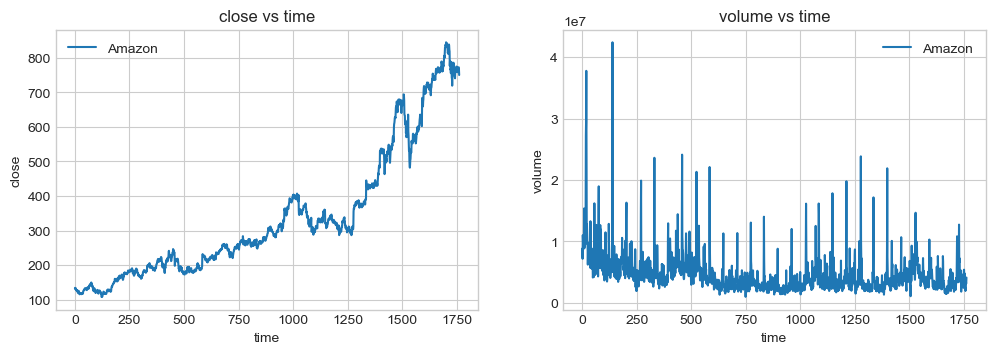

In [71]:
df_symbol = pd.get_dummies(df, columns = ['symbol'])
info = ['close', 'volume']
for i in range(2) :
    plt.subplot(2,2,i+1)
    plt.plot(df_symbol[df_symbol['symbol_AMZN'] == 1][info[i]].values)
    plt.xlabel('time' )
    plt.ylabel(info[i])
    plt.legend(['Amazon'])
    plt.title(info[i] + ' vs time')
plt.show()

In [72]:
# Select test dataframe with argument(dataframe, 'symbol_name', year)
# output = selection of 1 company for 1 year + create 2 new time variables
def df_symbol_year (df=df, symbol='AMZN', year=2016):
    mask = (df['symbol'] == symbol) & (df['year'] == year) # boolean criteria
    df = df.loc[mask, :] # dataframe with boolean criteria
    df = df[['date', 'symbol', 'close']] # selection of variables
    df.reset_index(drop=True, inplace=True) # reindex the dataframe
    
    # Create new variables with relative time in days and relative time in years
    dim = np.shape(df)[0]
    df['Relative Time (days)'] = 0
    start = df['date'][0]
    for i in range(1, dim):
        df['Relative Time (days)'][i] = (df['date'][i] - start).days
    df['Relative Time (years)'] = df['Relative Time (days)'] / 365
    #df.close = ( df.close - df.close.mean() ) / ( df.close.std() ) # normalize close values
    return (df)


In [73]:
AMZN_2015 = df_symbol_year(year=2015)
AMZN_2015

/var/folders/wj/2t2894gx1r17grsnfcv7knq80000gn/T/ipykernel_33107/1126024054.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Relative Time (days)'][i] = (df['date'][i] - start).days


date symbol       close  Relative Time (days)  Relative Time (years)
0   2015-01-02   AMZN  308.519989                     0               0.000000
1   2015-01-05   AMZN  302.190002                     3               0.008219
2   2015-01-06   AMZN  295.290009                     4               0.010959
3   2015-01-07   AMZN  298.420013                     5               0.013699
4   2015-01-08   AMZN  300.459991                     6               0.016438
..         ...    ...         ...                   ...                    ...
247 2015-12-24   AMZN  662.789978                   356               0.975342
248 2015-12-28   AMZN  675.200012                   360               0.986301
249 2015-12-29   AMZN  693.969971                   361               0.989041
250 2015-12-30   AMZN  689.070007                   362               0.991781
251 2015-12-31   AMZN  675.890015                   363               0.994521

[252 rows x 5 columns]

In [74]:
# Amazon observation used for calibration of GOU model
title_text = AMZN_2015['symbol'][0] + ' - ' + str(AMZN_2015['date'][0].year)
fig_data = go.Figure()
fig_data.add_trace(go.Scatter(x=AMZN_2015['Relative Time (years)'].values[:], y=AMZN_2015['close'].values[:], mode='lines+markers', name='data'))
fig_data.update_layout(title={'text': title_text,'x':0.5,'y':0.85}, xaxis_title='Relative Time (years)', yaxis_title='Stock option close value')
fig_data.show()

    Observation:
The Amazon stock option is increasing significantly during the year 2015

In [75]:
# Amazon observations to test the GOU model
AMZN_2016 = df_symbol_year(year=2016)
title_text = AMZN_2016['symbol'][0] + ' - ' + str(AMZN_2016['date'][0].year)
fig_data = go.Figure()
fig_data.add_trace(go.Scatter(x=AMZN_2016['Relative Time (years)'].values[:], y=AMZN_2016['close'].values[:], mode='lines+markers', name='data'))
fig_data.update_layout(title={'text': title_text,'x':0.5,'y':0.85}, xaxis_title='Relative Time (years)', yaxis_title='Stock option close value')
fig_data.show()

/var/folders/wj/2t2894gx1r17grsnfcv7knq80000gn/T/ipykernel_33107/1126024054.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



    Observation:
The Amazon stock option decreased significantly during the beginning of year 2016 during 0.1 year and restarted to increase after this fall down period.

## 6.1 Geometric Ornstein–Uhlenbeck Process Model (1 year forcasting)

    Observation:    

A Geometric Ornstein–Uhlenbeck Process (GOU) Model :
* models a continuous-time stochastic process,
* assumes the Markov process.
* is commonly used in mathematical finance to model stock prices.

## GOU Calibration

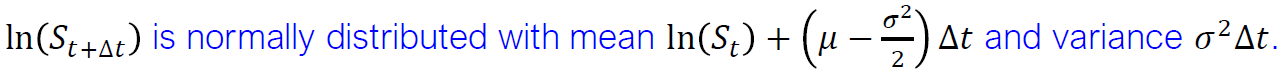

#### Calculate $\pi_t=ln(S_t)$

In [76]:
pi_t = np.log(AMZN_2015['close'].values[:]) # convert S to ln(S)
df_GOU_calibration = copy.deepcopy(AMZN_2015) # copy dataframe
df_GOU_calibration['pi_t'] = pi_t # create new variable
df_GOU_calibration

date symbol       close  Relative Time (days)  \
0   2015-01-02   AMZN  308.519989                     0   
1   2015-01-05   AMZN  302.190002                     3   
2   2015-01-06   AMZN  295.290009                     4   
3   2015-01-07   AMZN  298.420013                     5   
4   2015-01-08   AMZN  300.459991                     6   
..         ...    ...         ...                   ...   
247 2015-12-24   AMZN  662.789978                   356   
248 2015-12-28   AMZN  675.200012                   360   
249 2015-12-29   AMZN  693.969971                   361   
250 2015-12-30   AMZN  689.070007                   362   
251 2015-12-31   AMZN  675.890015                   363   

     Relative Time (years)      pi_t  
0                 0.000000  5.731787  
1                 0.008219  5.711056  
2                 0.010959  5.687958  
3                 0.013699  5.698502  
4                 0.016438  5.705315  
..                     ...       ...  
247               0.975342  6.496458  
248               0.986301  6.515009  
249               0.989041  6.542429  
250               0.991781  6.535343  
251               0.994521  6.516030  

[252 rows x 6 columns]

#### Let $x_t=\pi_t$ and $y_t=\pi_{t+dt}$

In [77]:
x_t = df_GOU_calibration['pi_t'].values[:]
y_t = df_GOU_calibration['pi_t'].values[1:]
y_t = np.append(y_t,float('nan')) # add NaN to last value of y_t
df_GOU_calibration['x_t'] = x_t # new variable
df_GOU_calibration['y_t'] = y_t # new variable
df_GOU_calibration

date symbol       close  Relative Time (days)  \
0   2015-01-02   AMZN  308.519989                     0   
1   2015-01-05   AMZN  302.190002                     3   
2   2015-01-06   AMZN  295.290009                     4   
3   2015-01-07   AMZN  298.420013                     5   
4   2015-01-08   AMZN  300.459991                     6   
..         ...    ...         ...                   ...   
247 2015-12-24   AMZN  662.789978                   356   
248 2015-12-28   AMZN  675.200012                   360   
249 2015-12-29   AMZN  693.969971                   361   
250 2015-12-30   AMZN  689.070007                   362   
251 2015-12-31   AMZN  675.890015                   363   

     Relative Time (years)      pi_t       x_t       y_t  
0                 0.000000  5.731787  5.731787  5.711056  
1                 0.008219  5.711056  5.711056  5.687958  
2                 0.010959  5.687958  5.687958  5.698502  
3                 0.013699  5.698502  5.698502  5.705315  
4                 0.016438  5.705315  5.705315  5.693496  
..                     ...       ...       ...       ...  
247               0.975342  6.496458  6.496458  6.515009  
248               0.986301  6.515009  6.515009  6.542429  
249               0.989041  6.542429  6.542429  6.535343  
250               0.991781  6.535343  6.535343  6.516030  
251               0.994521  6.516030  6.516030       NaN  

[252 rows x 8 columns]

#### Regress $y$ on $x$ to determine $a$ (slope) and $b$ (intercept)

In [78]:
# compute regression line parameters
regression = ss.linregress(x=x_t[:-1], y=y_t[:-1])
a = regression.slope
b = regression.intercept
print(a, b)

0.994886637522307 0.03452944801941893


#### Calculate regression residuals and the SD of the residuals 

In [79]:
y_reg = a*x_t + b
df_GOU_calibration['y_reg'] = y_reg
df_GOU_calibration

date symbol       close  Relative Time (days)  \
0   2015-01-02   AMZN  308.519989                     0   
1   2015-01-05   AMZN  302.190002                     3   
2   2015-01-06   AMZN  295.290009                     4   
3   2015-01-07   AMZN  298.420013                     5   
4   2015-01-08   AMZN  300.459991                     6   
..         ...    ...         ...                   ...   
247 2015-12-24   AMZN  662.789978                   356   
248 2015-12-28   AMZN  675.200012                   360   
249 2015-12-29   AMZN  693.969971                   361   
250 2015-12-30   AMZN  689.070007                   362   
251 2015-12-31   AMZN  675.890015                   363   

     Relative Time (years)      pi_t       x_t       y_t     y_reg  
0                 0.000000  5.731787  5.731787  5.711056  5.737007  
1                 0.008219  5.711056  5.711056  5.687958  5.716383  
2                 0.010959  5.687958  5.687958  5.698502  5.693403  
3                 0.013699  5.698502  5.698502  5.705315  5.703893  
4                 0.016438  5.705315  5.705315  5.693496  5.710671  
..                     ...       ...       ...       ...       ...  
247               0.975342  6.496458  6.496458  6.515009  6.497769  
248               0.986301  6.515009  6.515009  6.542429  6.516225  
249               0.989041  6.542429  6.542429  6.535343  6.543504  
250               0.991781  6.535343  6.535343  6.516030  6.536455  
251               0.994521  6.516030  6.516030       NaN  6.517241  

[252 rows x 9 columns]

In [80]:
fig_regression = go.Figure()
fig_regression.add_trace(go.Scatter(x=df_GOU_calibration['x_t'].values[:], y=df_GOU_calibration['y_t'].values[:], mode='markers', name='data for regression'))
fig_regression.add_trace(go.Scatter(x=df_GOU_calibration['x_t'].values[:], y=df_GOU_calibration['y_reg'].values[:], mode='lines', name='linear regression'))
fig_regression.update_layout(title={'text':'Linear Regression','x':0.5,'y':0.85}, xaxis_title='x', yaxis_title='y')
fig_regression.show()

    Observation:
The linear regression looks good

In [81]:
residuals = df_GOU_calibration['y_t'].values[:] - df_GOU_calibration['y_reg'].values[:]
df_GOU_calibration['residuals'] = residuals
df_GOU_calibration

date symbol       close  Relative Time (days)  \
0   2015-01-02   AMZN  308.519989                     0   
1   2015-01-05   AMZN  302.190002                     3   
2   2015-01-06   AMZN  295.290009                     4   
3   2015-01-07   AMZN  298.420013                     5   
4   2015-01-08   AMZN  300.459991                     6   
..         ...    ...         ...                   ...   
247 2015-12-24   AMZN  662.789978                   356   
248 2015-12-28   AMZN  675.200012                   360   
249 2015-12-29   AMZN  693.969971                   361   
250 2015-12-30   AMZN  689.070007                   362   
251 2015-12-31   AMZN  675.890015                   363   

     Relative Time (years)      pi_t       x_t       y_t     y_reg  residuals  
0                 0.000000  5.731787  5.731787  5.711056  5.737007  -0.025951  
1                 0.008219  5.711056  5.711056  5.687958  5.716383  -0.028425  
2                 0.010959  5.687958  5.687958  5.698502  5.693403   0.005099  
3                 0.013699  5.698502  5.698502  5.705315  5.703893   0.001422  
4                 0.016438  5.705315  5.705315  5.693496  5.710671  -0.017174  
..                     ...       ...       ...       ...       ...        ...  
247               0.975342  6.496458  6.496458  6.515009  6.497769   0.017240  
248               0.986301  6.515009  6.515009  6.542429  6.516225   0.026204  
249               0.989041  6.542429  6.542429  6.535343  6.543504  -0.008161  
250               0.991781  6.535343  6.535343  6.516030  6.536455  -0.020424  
251               0.994521  6.516030  6.516030       NaN  6.517241        NaN  

[252 rows x 10 columns]

In [82]:
residuals_sd = np.std(df_GOU_calibration['residuals'].values[:-1], ddof=1)
residuals_sd

0.02058142938803095

    Observation:
The residuals standard deviation is good

## Calculate GOU parameters: $\mu$, $\theta$, and $\sigma$

\begin{equation}
  \mu = \frac{b}{1-a}
\end{equation}

\begin{equation}
  \theta = - \frac{lna}{\Delta t}
\end{equation}

\begin{equation}
  \sigma = \sigma_{\epsilon} \sqrt{\frac{-2lna}{\Delta t(1-a^2)}}
\end{equation}


<b>Naming convention</b>:
* 𝝻 = GOU parameter
* a = slope of regression line
* b = intercept of regression line
* 𝝷 = GOU parameter
* △𝙩 = time between each value
* 𝞂ɛ = standard deviation of residuals from regression line

#### Calculate GOU parameters: $\mu$, $\theta$, and $\sigma$

In [83]:
dt = 1.4/365 # cotation every working day (estimated to 1.4 day)
mu_gou = b/(1-a)
theta_gou = -np.log(a)/dt
sigma_gou = residuals_sd*np.sqrt(-2*np.log(a)/(dt*(1-a**2)))
print(mu_gou, theta_gou, sigma_gou)

6.752787069184574 1.3365466894508782 0.3331733055998743


#### Calculate the GOU mean and SD of $ln(S_t)$

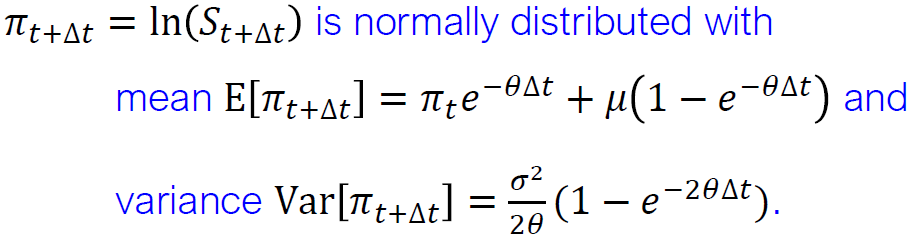

In [84]:
S_0 = AMZN_2015['close'].values[0]
lnS_0 = np.log(S_0)
times_years = AMZN_2015['Relative Time (years)'].values[:]
lnS_t_mean_gou = lnS_0*np.exp(-theta_gou*times_years)+mu_gou*(1-np.exp(-theta_gou*times_years))
lnS_t_var_gou = sigma_gou**2/(2*theta_gou)*(1-np.exp(-2*theta_gou*times_years))

#### Calculate the GOU mean of $S_t$

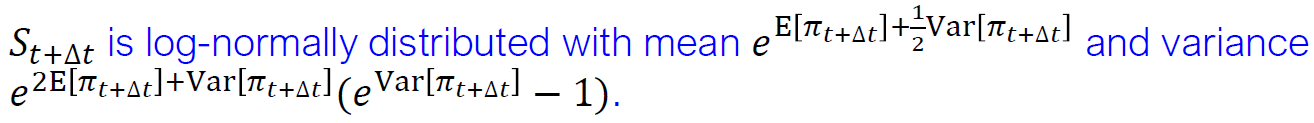

In [85]:
S_t_mean_gou = np.exp(lnS_t_mean_gou + lnS_t_var_gou/2)
df_GOU_calibration['Calibrated Mean'] = S_t_mean_gou # new variable
df_GOU_calibration

date symbol       close  Relative Time (days)  \
0   2015-01-02   AMZN  308.519989                     0   
1   2015-01-05   AMZN  302.190002                     3   
2   2015-01-06   AMZN  295.290009                     4   
3   2015-01-07   AMZN  298.420013                     5   
4   2015-01-08   AMZN  300.459991                     6   
..         ...    ...         ...                   ...   
247 2015-12-24   AMZN  662.789978                   356   
248 2015-12-28   AMZN  675.200012                   360   
249 2015-12-29   AMZN  693.969971                   361   
250 2015-12-30   AMZN  689.070007                   362   
251 2015-12-31   AMZN  675.890015                   363   

     Relative Time (years)      pi_t       x_t       y_t     y_reg  residuals  \
0                 0.000000  5.731787  5.731787  5.711056  5.737007  -0.025951   
1                 0.008219  5.711056  5.711056  5.687958  5.716383  -0.028425   
2                 0.010959  5.687958  5.687958  5.698502  5.693403   0.005099   
3                 0.013699  5.698502  5.698502  5.705315  5.703893   0.001422   
4                 0.016438  5.705315  5.705315  5.693496  5.710671  -0.017174   
..                     ...       ...       ...       ...       ...        ...   
247               0.975342  6.496458  6.496458  6.515009  6.497769   0.017240   
248               0.986301  6.515009  6.515009  6.542429  6.516225   0.026204   
249               0.989041  6.542429  6.542429  6.535343  6.543504  -0.008161   
250               0.991781  6.535343  6.535343  6.516030  6.536455  -0.020424   
251               0.994521  6.516030  6.516030       NaN  6.517241        NaN   

     Calibrated Mean  
0         308.519989  
1         312.121481  
2         313.322105  
3         314.522763  
4         315.723440  
..               ...  
247       661.666404  
248       664.368610  
249       665.039637  
250       665.708860  
251       666.376279  

[252 rows x 11 columns]

In [92]:
fig_GOU_cali = go.Figure()
fig_GOU_cali.add_trace(go.Scatter(x=df_GOU_calibration['Relative Time (years)'].values[:], y=df_GOU_calibration['close'].values[:], mode='lines+markers', name='data', marker_color=0))
fig_GOU_cali.add_trace(go.Scatter(x=df_GOU_calibration['Relative Time (years)'].values[:], y=df_GOU_calibration['Calibrated Mean'].values[:], mode='lines', name='GOU Mean'))
fig_GOU_cali.update_layout(title={'text':'GOU Calibration','x':0.5,'y':0.85}, xaxis_title='Relative Time (years)', yaxis_title='Stock option close')
fig_GOU_cali.show()

    Observation:
* If the interval of time between each value is dt = 1 day = = 1/365 year, the GOU mean curve is over the data plot
* Correction made: dt = 1.4/365 in order to have a better coincidence between data and GOU mean (no trading during the week end).

#### Calculate the GOU P10 and P90 of $ln(S)$

In [91]:
lnS_t_P10_gou = ss.norm.ppf(q=0.05, loc=lnS_t_mean_gou, scale=np.sqrt(lnS_t_var_gou))
lnS_t_P10_gou[0] = np.log(S_0)
lnS_t_P90_gou = ss.norm.ppf(q=0.95, loc=lnS_t_mean_gou, scale=np.sqrt(lnS_t_var_gou))
lnS_t_P90_gou[0] = np.log(S_0)

/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning:

invalid value encountered in multiply

/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning:

invalid value encountered in multiply



#### Calculate the GOU P10 and P90 of $S$

In [89]:
S_t_P10_gou = np.exp(lnS_t_P10_gou)
S_t_P90_gou = np.exp(lnS_t_P90_gou)
df_GOU_calibration['Calibrated P10'] = S_t_P10_gou
df_GOU_calibration['Calibrated P90'] = S_t_P90_gou
df_GOU_calibration

date symbol       close  Relative Time (days)  \
0   2015-01-02   AMZN  308.519989                     0   
1   2015-01-05   AMZN  302.190002                     3   
2   2015-01-06   AMZN  295.290009                     4   
3   2015-01-07   AMZN  298.420013                     5   
4   2015-01-08   AMZN  300.459991                     6   
..         ...    ...         ...                   ...   
247 2015-12-24   AMZN  662.789978                   356   
248 2015-12-28   AMZN  675.200012                   360   
249 2015-12-29   AMZN  693.969971                   361   
250 2015-12-30   AMZN  689.070007                   362   
251 2015-12-31   AMZN  675.890015                   363   

     Relative Time (years)      pi_t       x_t       y_t     y_reg  residuals  \
0                 0.000000  5.731787  5.731787  5.711056  5.737007  -0.025951   
1                 0.008219  5.711056  5.711056  5.687958  5.716383  -0.028425   
2                 0.010959  5.687958  5.687958  5.698502  5.693403   0.005099   
3                 0.013699  5.698502  5.698502  5.705315  5.703893   0.001422   
4                 0.016438  5.705315  5.705315  5.693496  5.710671  -0.017174   
..                     ...       ...       ...       ...       ...        ...   
247               0.975342  6.496458  6.496458  6.515009  6.497769   0.017240   
248               0.986301  6.515009  6.515009  6.542429  6.516225   0.026204   
249               0.989041  6.542429  6.542429  6.535343  6.543504  -0.008161   
250               0.991781  6.535343  6.535343  6.516030  6.536455  -0.020424   
251               0.994521  6.516030  6.516030       NaN  6.517241        NaN   

     Calibrated Mean  Calibrated P10  Calibrated P90  
0         308.519989      308.519989      308.519989  
1         312.121481      296.939815      327.783410  
2         313.322105      295.799077      331.485553  
3         314.522763      294.933992      334.912139  
4         315.723440      294.263575      338.144116  
..               ...             ...             ...  
247       661.666404      470.095230      896.163964  
248       664.368610      471.819363      900.117509  
249       665.039637      472.247867      901.098758  
250       665.708860      472.675361      902.077164  
251       666.376279      473.101845      903.052730  

[252 rows x 13 columns]

In [93]:
fig_GOU_cali.add_trace(go.Scatter(x=df_GOU_calibration['Relative Time (years)'].values[:], y=df_GOU_calibration['Calibrated P10'].values[:], mode='lines', name='GOU P10'))
fig_GOU_cali.add_trace(go.Scatter(x=df_GOU_calibration['Relative Time (years)'].values[:], y=df_GOU_calibration['Calibrated P90'].values[:], mode='lines', name='GOU P90'))
fig_GOU_cali.show()

## GOU Forecasting (1 year)

In [94]:
df_GOU_forecasting = pd.DataFrame(data={'Relative Time (days)': np.arange(365)})
df_GOU_forecasting['Relative Time (years)'] = df_GOU_forecasting['Relative Time (days)'].values[:]/365
df_GOU_forecasting

Relative Time (days)  Relative Time (years)
0                       0               0.000000
1                       1               0.002740
2                       2               0.005479
3                       3               0.008219
4                       4               0.010959
..                    ...                    ...
360                   360               0.986301
361                   361               0.989041
362                   362               0.991781
363                   363               0.994521
364                   364               0.997260

[365 rows x 2 columns]

#### Calculate forecasted mean

In [95]:
S_0 = df_GOU_calibration['close'].values[-1]
lnS_0 = np.log(S_0)
times_years = df_GOU_forecasting['Relative Time (years)'].values[:]
lnS_t_mean_gou = lnS_0*np.exp(-theta_gou*times_years)+mu_gou*(1-np.exp(-theta_gou*times_years))
lnS_t_var_gou = sigma_gou**2/(2*theta_gou)*(1-np.exp(-2*theta_gou*times_years))
S_t_mean_gou = np.exp(lnS_t_mean_gou+lnS_t_var_gou/2)
df_GOU_forecasting['Forecasted Mean'] = S_t_mean_gou
df_GOU_forecasting

Relative Time (days)  Relative Time (years)  Forecasted Mean
0                       0               0.000000       675.890015
1                       1               0.002740       676.577656
2                       2               0.005479       677.263106
3                       3               0.008219       677.946370
4                       4               0.010959       678.627453
..                    ...                    ...              ...
360                   360               0.986301       819.509356
361                   361               0.989041       819.708051
362                   362               0.991781       819.906035
363                   363               0.994521       820.103311
364                   364               0.997260       820.299882

[365 rows x 3 columns]

In [96]:
fig_GOU_fore = go.Figure()
fig_GOU_fore.add_trace(go.Scatter(x=df_GOU_calibration['Relative Time (years)'].values[:]-df_GOU_calibration['Relative Time (years)'].values[-1], y=df_GOU_calibration['close'].values[:], mode='lines+markers', name='data', marker_color='black'))
fig_GOU_fore.add_trace(go.Scatter(x=df_GOU_forecasting['Relative Time (years)'].values[:], y=df_GOU_forecasting['Forecasted Mean'].values[:], mode='lines', name='GOU Mean'))
fig_GOU_fore.update_layout(title={'text':'GOU Forecasting 2015 <- 0 -> 2016','x':0.5,'y':0.85}, xaxis_title='Relative Time (years)', yaxis_title='Stock option close')
fig_GOU_fore.show()

#### Calculate forecasted with P5 and P95

In [97]:
lnS_t_P5_gou = ss.norm.ppf(q=0.05, loc=lnS_t_mean_gou, scale=np.sqrt(lnS_t_var_gou))
lnS_t_P5_gou[0] = np.log(S_0)

lnS_t_P95_gou = ss.norm.ppf(q=0.95, loc=lnS_t_mean_gou, scale=np.sqrt(lnS_t_var_gou))
lnS_t_P95_gou[0] = np.log(S_0)

S_t_P5_gou = np.exp(lnS_t_P5_gou)
S_t_P95_gou = np.exp(lnS_t_P95_gou)

df_GOU_forecasting['Forecasted P5'] = S_t_P5_gou
df_GOU_forecasting['Forecasted P95'] = S_t_P95_gou
df_GOU_forecasting.head()

/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning:

invalid value encountered in multiply

/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning:

invalid value encountered in multiply



Relative Time (days)  Relative Time (years)  Forecasted Mean  \
0                     0               0.000000       675.890015   
1                     1               0.002740       676.577656   
2                     2               0.005479       677.263106   
3                     3               0.008219       677.946370   
4                     4               0.010959       678.627453   

   Forecasted P5  Forecasted P95  
0     675.890015      675.890015  
1     657.380776      696.124160  
2     650.238788      704.984765  
3     644.970892      711.965010  
4     640.674154      717.967846

In [98]:
fig_GOU_fore.add_trace(go.Scatter(x=df_GOU_forecasting['Relative Time (years)'].values[:], y=df_GOU_forecasting['Forecasted P5'].values[:], mode='lines', name='GOU P5'))
fig_GOU_fore.add_trace(go.Scatter(x=df_GOU_forecasting['Relative Time (years)'].values[:], y=df_GOU_forecasting['Forecasted P95'].values[:], mode='lines', name='GOU P95'))
fig_GOU_fore.show()

#### Generate forecasted realizations

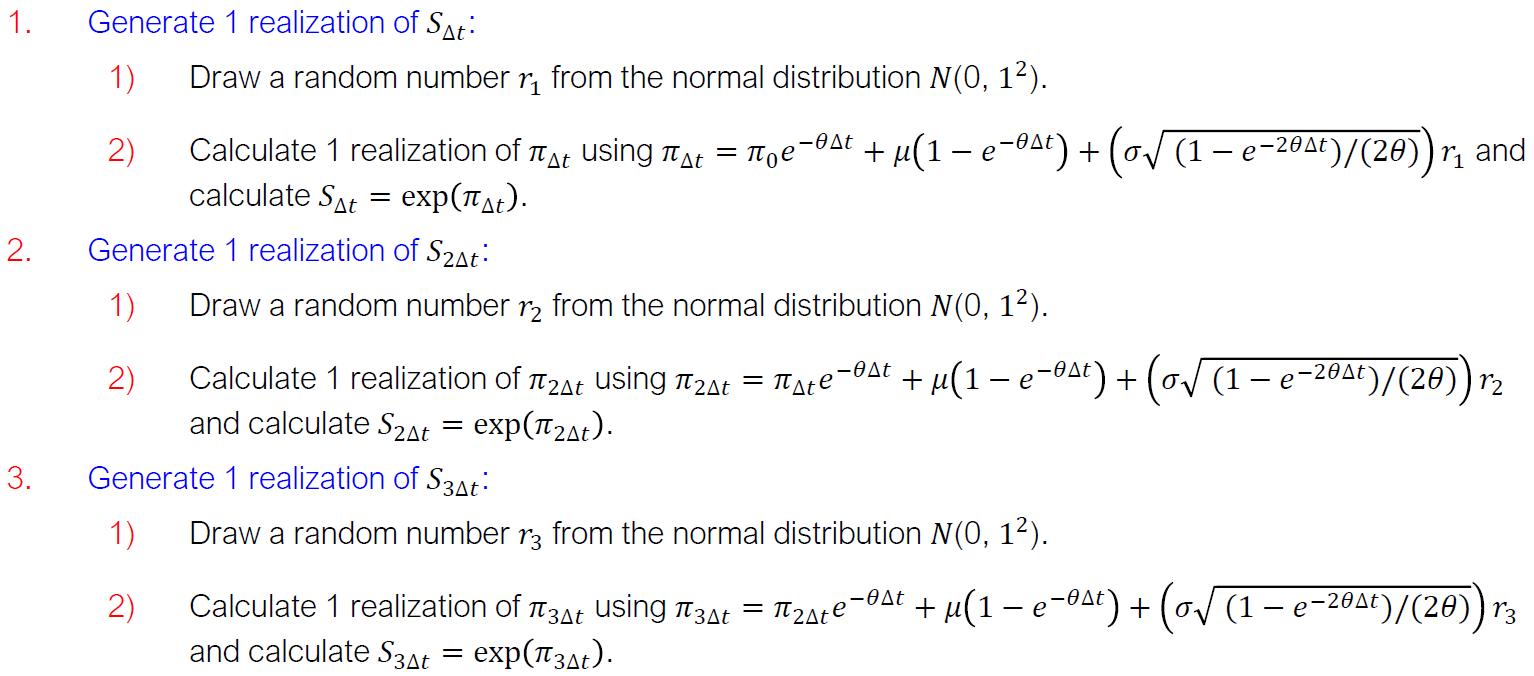

In [99]:

# draw realization number n on previous graphic
def forecast_real (n):
# draw random number from normal distribution N(0,1)
    r_values = ss.norm.rvs(loc=0, scale=1, size=len(times_years)-1)
# generate sample for realization 1
    lnS_sample_times = [np.log(df_GOU_calibration['close'].values[-1])]
    for k in range(len(times_years)-1):
        lnS_sample_previous = lnS_sample_times[k]
        r = r_values[k]
        lnS_sample_next = lnS_sample_previous*np.exp(-theta_gou*dt)+mu_gou*(1-np.exp(-theta_gou*dt))+(sigma_gou*np.sqrt((1-np.exp(-2*theta_gou*dt))/(2*theta_gou)))*r
        lnS_sample_times.append(lnS_sample_next)
    S_sample_times = np.exp(lnS_sample_times)
    #title_text = company['symbol'][0] + ' - ' + str(company['date'][0].year)
    new_real = 'Realization ' + str(n)
    df_GOU_forecasting[new_real] = S_sample_times
    fig_GOU_fore.add_trace(go.Scatter(x=df_GOU_forecasting['Relative Time (years)'].values[:], y=df_GOU_forecasting[new_real].values[:], mode='lines', name=new_real))
    fig_GOU_fore.show()

In [100]:
random.seed(8)
forecast_real(1)
forecast_real(2)
forecast_real(3)
fig_GOU_fore.add_trace(go.Scatter(x=AMZN_2016['Relative Time (years)'].values[:], y=AMZN_2016['close'].values[:], mode='lines+markers', name='data', marker_color='black'))
fig_GOU_fore.show()

    Observation:
We can see that the real observations in 2016 are going down outside the 95% interval of GOU forecasting model.

1. The stock option close value decreased significantly in the beginning of 2016 and recover its previous value (end 2015) after 0.3 year.
2. The prediction (2016) from GOU model refers to old observations (2015) that increased globally during 2015. 
3. Only 1 realization (#1) predicted a decrease of the AMZN stock option value
    
In this context (3 realizations), it was difficult to predict a major decrease of the close value.

The positives points are:
1. After 0.2 year, the data are inside the 95% GOU confidence interval
2. The real data 2016 join the GOU mean after 0.6 year in 2016

`Conclusion:`
    
* The GOU model is not very efficient in case of a significant change (up or down) in the stock option value.
* This model could be used in order to have a long trend perspective (confidence interval to evaluate the risk) and assume that the stock option will join the GOU mean
* This model could be very interesting to have a kind of short term trend that will be revised every day in order to capture any signal of change.

## 6.2 Linear regression Model (2 months)

In [101]:
mask = (df['symbol'] == 'AMZN') # boolean criteria
df_AMZN = df.loc[mask, :] # dataframe with boolean criteria
df_AMZN.reset_index(drop=True, inplace=True) # reindex the dataframe
df_AMZN = df_AMZN[['date', 'close']] # selection of variables
df_AMZN

date       close
0    2010-01-04  133.899994
1    2010-01-05  134.690002
2    2010-01-06  132.250000
3    2010-01-07  130.000000
4    2010-01-08  133.520004
...         ...         ...
1757 2016-12-23  760.590027
1758 2016-12-27  771.400024
1759 2016-12-28  772.130005
1760 2016-12-29  765.150024
1761 2016-12-30  749.869995

[1762 rows x 2 columns]

In [102]:
predict_variable = 'close'
predict_result = 60 # duration of prediction
data_test_ratio = 0.3 # ratio of data to test

In [103]:
def company_predict(data, predict_variable, predict_result, data_test_ratio):
    label = data[predict_variable].shift(-predict_result)
    x = np.array(data[[predict_variable]])
    x = preprocessing.scale(x)
    x_predict = x[-predict_result:]
    x = x[:-predict_result]
    label.dropna(inplace=True)
    y = np.array(label)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=data_test_ratio, random_state=3)
    result = [x_train, x_test, y_train, y_test, x_predict]
    return result

In [104]:
x_train, x_test, y_train, y_test, x_predict = company_predict(df_AMZN, predict_variable, predict_result, data_test_ratio)
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [105]:
AMZN_score = lr.score(x_test, y_test)
AMZN_score

0.9203911578324643

    Observation:
The score (92%) is supposed to be very efficient

In [106]:
predict = lr.predict(x_predict)
predict

array([896.8949063 , 894.53073338, 896.94796709, 885.59345091,
       888.86942566, 883.76997767, 877.06965327, 866.45727354,
       871.44011692, 871.48250067, 863.66900342, 872.8607177 ,
       893.1101326 , 890.02498225, 876.67739318, 872.19280106,
       827.62299437, 841.93538031, 837.25996486, 816.21548314,
       817.7739758 , 805.07301503, 836.75110123, 839.74080705,
       822.91580753, 791.6405938 , 788.0678035 , 766.92787618,
       792.55232989, 795.99790428, 806.50429179, 810.49050225,
       831.52443734, 837.17519737, 831.65165324, 831.91669743,
       817.49832031, 812.99256918, 800.32344339, 792.9870384 ,
       789.47785658, 809.64237359, 815.32490605, 821.36792617,
       818.0920161 , 819.50200452, 810.44811851, 825.52386563,
       819.67166884, 811.38107934, 807.95672968, 816.68196302,
       822.21605484, 821.55875057, 817.04245174, 810.9464355 ,
       822.40694284, 823.18085172, 815.78083824, 799.58130695])

In [107]:
predict.size

60

In [108]:
df_lr_forecasting = pd.DataFrame(data={'Relative Time (days)': np.arange(60)})
df_lr_forecasting['Relative Time (years)'] = df_lr_forecasting['Relative Time (days)'].values[:]/365
df_lr_forecasting['close'] = predict
df_lr_forecasting.head()

Relative Time (days)  Relative Time (years)       close
0                     0               0.000000  896.894906
1                     1               0.002740  894.530733
2                     2               0.005479  896.947967
3                     3               0.008219  885.593451
4                     4               0.010959  888.869426

In [109]:
fig_lr_predict = go.Figure()
fig_lr_predict.add_trace(go.Scatter(x=AMZN_2015['Relative Time (years)'].values[:]-AMZN_2015['Relative Time (years)'].values[-1], y=AMZN_2015['close'].values[:], mode='lines+markers', name='data', marker_color='black'))
fig_lr_predict.add_trace(go.Scatter(x=df_lr_forecasting['Relative Time (years)'].values[:], y=df_lr_forecasting['close'].values[:], mode='lines', name='prediction'))
fig_lr_predict.add_trace(go.Scatter(x=AMZN_2016['Relative Time (years)'].values[:], y=AMZN_2016['close'].values[:], mode='lines+markers', name='data', marker_color='black'))
fig_lr_predict.update_layout(title={'text':'Linear regression model (Amazon)','x':0.5,'y':0.85}, xaxis_title='Relative Time (years)', yaxis_title='Stock option close')
fig_lr_predict.show()

    Observation:
1. The stock option close value decreased significantly in the beginning of 2016 and recover its previous value (end 2015) after 0.3 year.
2. The prediction (2016) using a linear regression follows quite the same decreasing trend but with a kind of over-evaluation from the beginning. The curve has an upward transition.
3. We need more time to investigate about this gap.

`Conclusion:`
    
* As this stage, hte linear regression Model is useless until we find the source of gap.

## 6.3. Long Short Term Memory Model (2 years)

LSTM network to predict the closing stock price using the past 70% of stock option

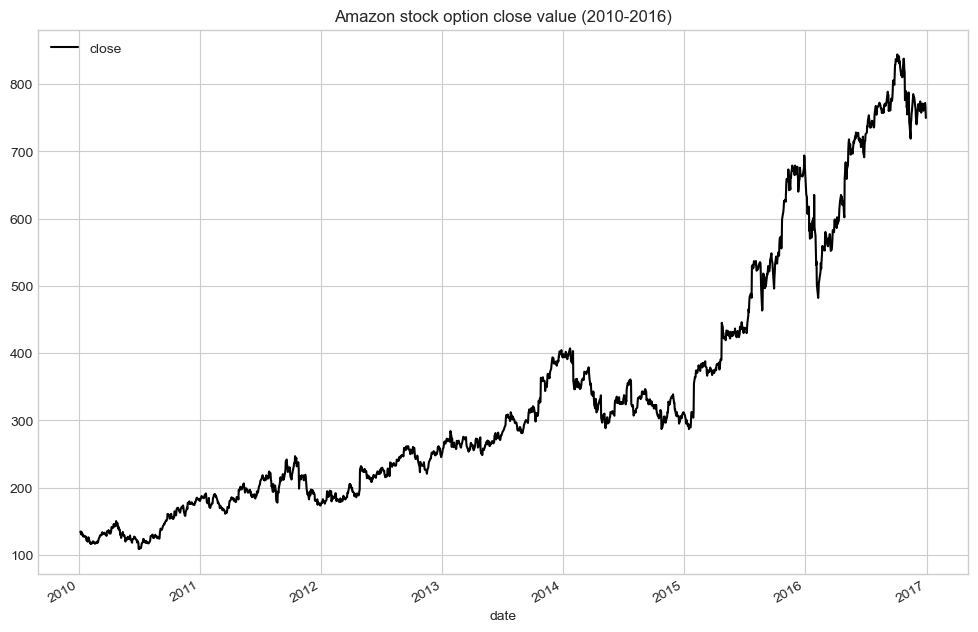

In [146]:
#  Plotting date vs the close market stock price
df_AMZN.plot('date','close',color="black")
plt.title('Amazon stock option close value (2010-2016)')
plt.show()

Creating a new Dataframe and Training data

In [147]:
# Convert the data into array for calculation
array_AMZN = df_AMZN.filter(['close']).values
array_AMZN

array([[133.899994],
       [134.690002],
       [132.25    ],
       ...,
       [772.130005],
       [765.150024],
       [749.869995]])

In [148]:
# Scale/Normalize the data to make all values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(array_AMZN)
scaled_data

array([[0.03437308],
       [0.03544683],
       [0.03213048],
       ...,
       [0.90182809],
       [0.8923412 ],
       [0.87157324]])

In [149]:
# Creating training data size = 70% of the dataset
training_data_len = math.ceil(len(array_AMZN) * .7)
train_data = scaled_data[0:training_data_len  , : ]
print(len(train_data)) # number of observations used for the training
train_data

1234


array([[0.03437308],
       [0.03544683],
       [0.03213048],
       ...,
       [0.30447844],
       [0.30856951],
       [0.30775401]])

In [150]:
# Separating the data into x and y data
x_train_data = []
y_train_data = []
for i in range(90, len(train_data)):
    x_train_data=list(x_train_data)
    y_train_data=list(y_train_data)
    x_train_data.append(train_data[i-90:i,0])
    y_train_data.append(train_data[i,0])

# Convert the training x and y values to numpy arrays
x_train_array, y_train_array = np.array(x_train_data), np.array(y_train_data)

# Reshape training s and y data in a 3 dimensional array
x_train_array3D = np.reshape(x_train_array, (x_train_array.shape[0],x_train_array.shape[1],1))
x_train_array3D

array([[[0.03437308],
        [0.03544683],
        [0.03213048],
        ...,
        [0.03082568],
        [0.0296976 ],
        [0.03433231]],

       [[0.03544683],
        [0.03213048],
        [0.02907237],
        ...,
        [0.0296976 ],
        [0.03433231],
        [0.03107034]],

       [[0.03213048],
        [0.02907237],
        [0.03385661],
        ...,
        [0.03433231],
        [0.03107034],
        [0.02707441]],

       ...,

       [[0.33141694],
        [0.3398573 ],
        [0.34135238],
        ...,
        [0.29401291],
        [0.29620117],
        [0.3016378 ]],

       [[0.3398573 ],
        [0.34135238],
        [0.34282025],
        ...,
        [0.29620117],
        [0.3016378 ],
        [0.30447844]],

       [[0.34135238],
        [0.34282025],
        [0.33915055],
        ...,
        [0.3016378 ],
        [0.30447844],
        [0.30856951]]])

In [151]:
random.seed(24)
model = Sequential()
model.add(LSTM(units=60, return_sequences=True, input_shape=(x_train_array3D.shape[1], 1)))
model.add(LSTM(units=60, return_sequences=False))
model.add(Dense(units=20))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train_array3D, y_train_array, batch_size=1, epochs=1)

1144/1144 [==============================] - 50s 40ms/step - loss: 3.8592e-04


    Observation:
* The units values affect the root mean squared error which is supposed to be as less as possible.
* It is difficult to choose the good values.

In [152]:
# Creating a dataset for testing
test_data = scaled_data[training_data_len-90: , : ]
x_test = []
y_test =  array_AMZN[training_data_len : , : ]
for i in range(90,len(test_data)):
    x_test.append(test_data[i-90:i,0])

# Convert the values into arrays 
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [153]:
# Making predictions on the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)# 

17/17 [==============================] - 2s 34ms/step


In [118]:
# root mean squared error to measure the accuracy of the model
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

19.114034914930627

    Observation:
The root mean squared error is not perfect (lower as possible) but acceptable

/var/folders/wj/2t2894gx1r17grsnfcv7knq80000gn/T/ipykernel_33107/471019954.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



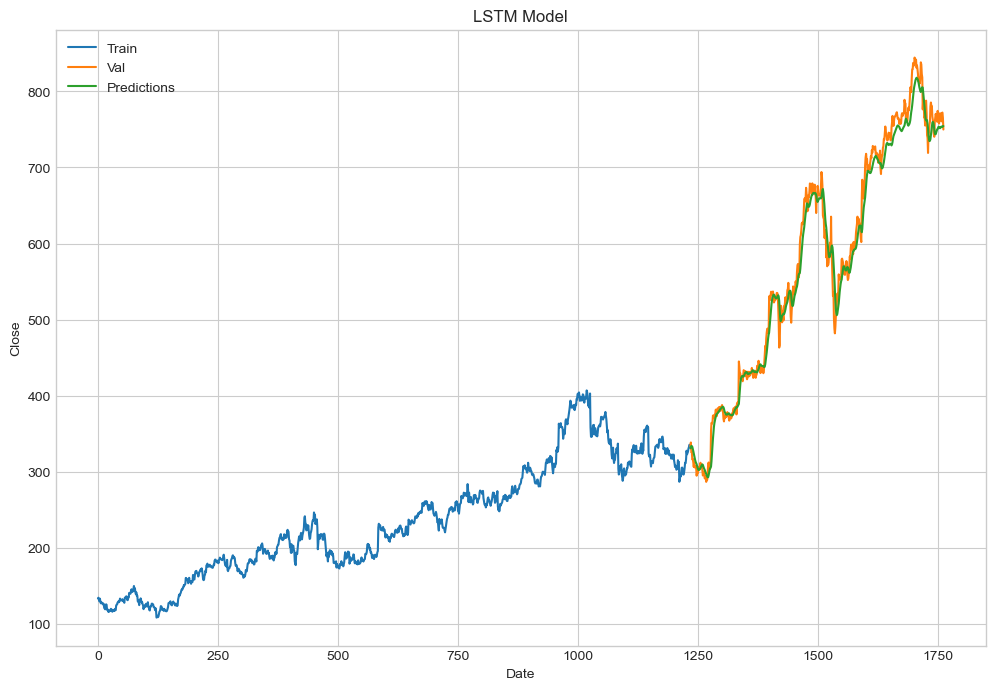

In [119]:
train = df_AMZN[:training_data_len]
valid = df_AMZN[training_data_len:]
 
valid['Predictions'] = predictions
 
plt.title('LSTM Model')
plt.xlabel('Date')
plt.ylabel('Close')
 
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
 
plt.legend(['Train', 'Val', 'Predictions'], loc='best')
 
plt.show()

    Observation:
The Long Short Term Memory Model produce predictions fitting quite well with the data (acceptable incertainty).

## 6.4. SARIMAX Model (90 days)

In [154]:
# The train_test_Split function gives a tuple with two elements the first one is train and the second is test
train, test  = train_test_Split(series= series_wo_anomaly, ratio= .90)

In [155]:
# Function ´best_model_order´finds the best value for order parameters based on less rms
order_1 = [2]
order_2 = [0]
order_3 = [1]
seasonal_order = (1,1,1,10)
model_order_level = best_model_order(train, test, order_1= order_1, order_2= order_2, order_3= order_3,seasonal_order=  seasonal_order)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.55301D+00    |proj g|=  4.81845D+01

At iterate    5    f=  4.68496D+00    |proj g|=  1.04517D+02

At iterate   10    f=  3.46763D+00    |proj g|=  4.89503D+00

At iterate   15    f=  3.43675D+00    |proj g|=  1.05869D+00

At iterate   20    f=  3.29568D+00    |proj g|=  7.93668D-01

At iterate   25    f=  3.29197D+00    |proj g|=  1.29963D+00

At iterate   30    f=  3.19788D+00    |proj g|=  3.00988D+01

At iterate   35    f=  3.14553D+00    |proj g|=  1.59041D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     80      2     0     0   3.517D+01   3.143D+00
  F =   3.1432506486075114     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Mean square root error is: 52.89281810663792
Best model rms is: 52.89281810663792.
 The parameters are:
order #1:  2
order #2:  0
order #3:  1



In [156]:
# Function ´best_model´gives the best value for seasonal order to have the less rms
best_order = model_order_level.get('order')
seas_1 = [2]
seas_2 = [2]
seas_3 = [1]
seas_4 = [11]
best_model = best_model(train, test, order= best_order, seas_1= seas_1, seas_2= seas_2, seas_3= seas_3, seas_4= seas_4)

TypeError: 'dict' object is not callable

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.73235D+00    |proj g|=  2.28162D+00


 This problem is unconstrained.



At iterate    5    f=  4.41360D+00    |proj g|=  4.10490D+01

At iterate   10    f=  3.71634D+00    |proj g|=  6.57225D-01

At iterate   15    f=  3.64755D+00    |proj g|=  3.14083D-01

At iterate   20    f=  3.64509D+00    |proj g|=  2.43741D-01

At iterate   25    f=  3.59496D+00    |proj g|=  2.63514D-01

At iterate   30    f=  3.58050D+00    |proj g|=  1.55292D+01

At iterate   35    f=  3.56368D+00    |proj g|=  4.92115D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     63      1     0     0   4.921D+01   3.564D+00
  F =   3.5636818459318209     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

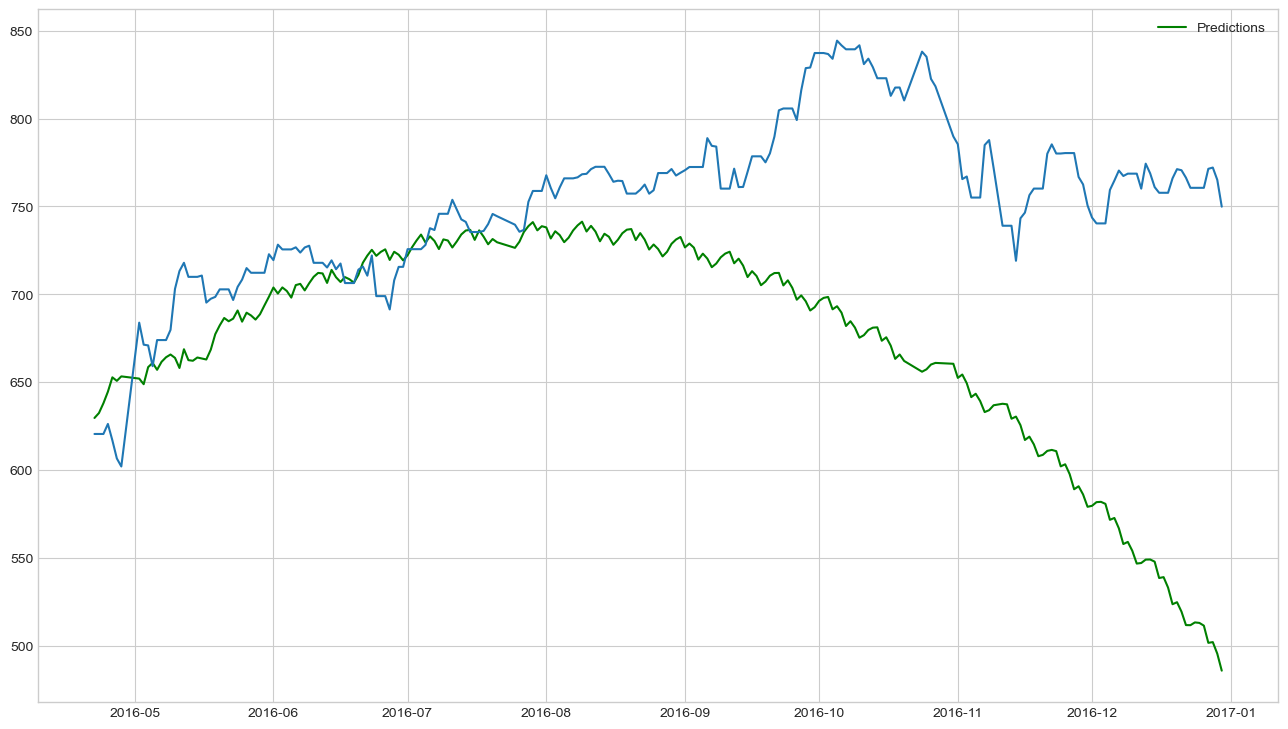

In [157]:
best_seasonality = best_model.get('seasonality')
best_model_var= sarimax_model(train, test, order = (2,0,1),seasonal_order = (2,2,1,11), trend = 'ct')
fig = plt.figure(figsize = (16,9))
plt.plot(best_model_var[2], color='green', label = 'Predictions')
plt.plot(test)
plt.legend()

    Observation:
The model is keeping the trend as same as real data but with some gaps. It sometimes predicts overestimate and sometimes predicts underestimate.

There are 159 days without data. These days will be filled up using forward filling method...
Non-trading days filled up. The dataframe has now 2552 records


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.71273D+00    |proj g|=  2.14600D+00


 This problem is unconstrained.



At iterate    5    f=  3.81203D+00    |proj g|=  1.04432D+01

At iterate   10    f=  3.74032D+00    |proj g|=  1.50410D+01

At iterate   15    f=  3.70362D+00    |proj g|=  1.54293D+00

At iterate   20    f=  3.70204D+00    |proj g|=  1.36669D+00

At iterate   25    f=  3.69572D+00    |proj g|=  6.10792D+00

At iterate   30    f=  3.59984D+00    |proj g|=  1.37670D+02

At iterate   35    f=  3.44155D+00    |proj g|=  5.09416D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  3.38447D+00    |proj g|=  1.20605D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     40     93      2     0     0   1.206D+02   3.384D+00
  F =   3.3844713604131047     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


There are 159 days without data. These days will be filled up using forward filling method...
Non-trading days filled up. The dataframe has now 2552 records


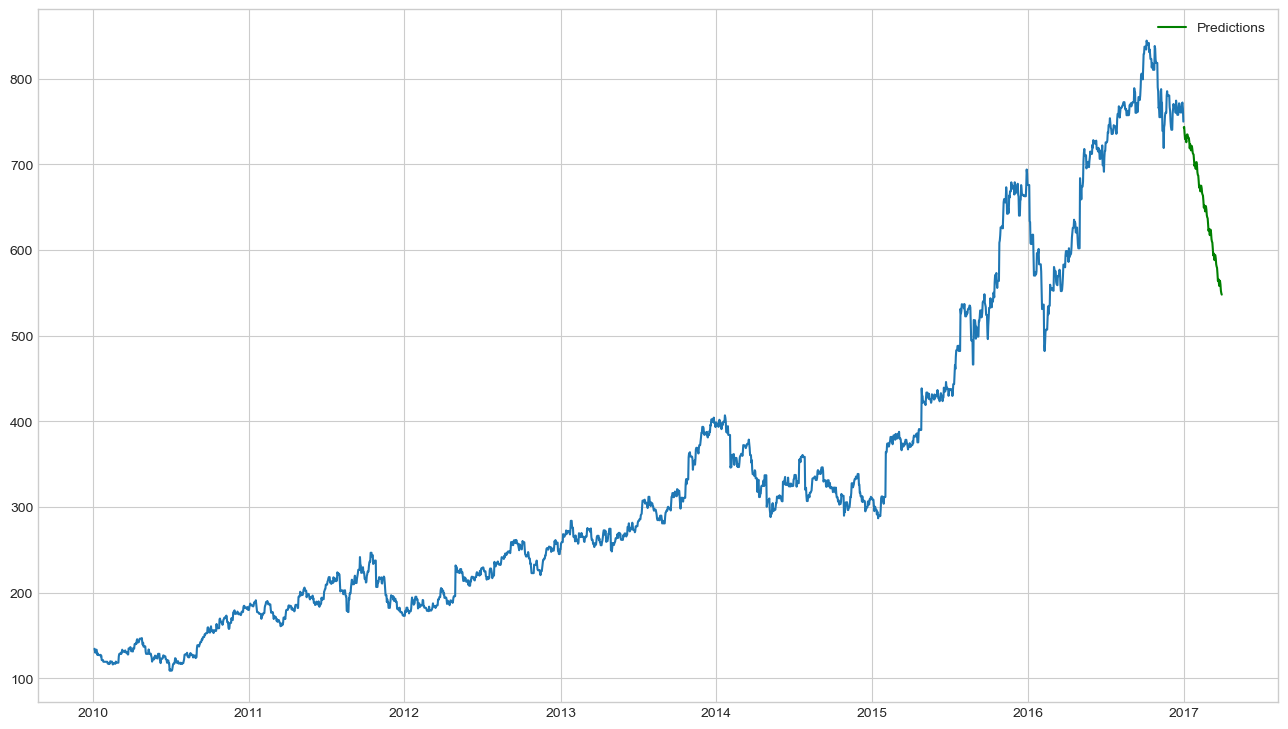

In [144]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
ARMAmodel = SARIMAX(fillup_days(series_wo_anomaly), order=best_order,seasonal_order=best_seasonality, trend = 'ct')
ARMAmodel = ARMAmodel.fit()
forecast = ARMAmodel.forecast(90)
fig = plt.figure(figsize = (16,9))
plt.plot(forecast, color='green', label = 'Predictions')
plt.plot(fillup_days(series_wo_anomaly))
plt.legend()

    Observation:
* It is predicted for 90 days after 2016. Although we do not have real data at this period to validate. 
* It just shows a downward trend for close price.


## 7. Conclusion

**`Data preparation`**:
* The **data preparation** is important to better understand the data we will use
* The **visualisation** is also important to confirm or preview some kind of *data behaviors*
* Before posing any **problematic**, it's wise to make sure that the available *data* could give an answer to the problematic

**`Data anomaly`**:

* Two methods for anomaly detection are used from ADTK (Anomaly Detection Tool Kit).
* Based on these methods for ´volume´ variable, peaks were detected as anomalies.
* Based on these methods for ´close´ variable, no seasonality were found.
* Based on threshhold method anomalies were detected for ´close_change´ variable.
* The days with three TRUE from the three anomaly analysis (volume_seasonality, volume_threshhold, close_change threshhold) are considered as anomalies. 

**`Model for prediction`**:

Using different **Models** is interesting to compare the results and have a better understanding of each Model

1. **<u>GOU Model</u>**:
* It was necessary to **tune one parameter of the model** (dt) in order to *better fit* with the data before prediction
* It would be more effective to keep dt=1 day and fulfill the gap (missing days) with the previous value and run the model.
* As for the prediction, it's wise to predict in a **very short term** in order to capture any *daily changes* for the next prediction

`Accuracy`:  the residuals standard deviation for GOU Calibration is good: = 0.02

2. **<u>Linear regression</u>**:
* As it is, the prediction is not acceptable before of the real gap with the real data. this problem request more time to investigate.

`Accuracy`: The linear regression score (92%) is supposed to be very efficient

3. **<u>LSTM Model</u>**:

The key points are:
* How many model.add(LSTM) and model.add(Dense) to add
* choose the good units values paramaters for model.add(LSTM(units=) and model.add(Dense(units=)

These choices affect significantly the root mean squared error that is supposed to be as less as possible.
This Model is a good model fiting with the data.

`Accuracy`:
The root mean squared error is not perfect (∼19) but acceptable

4. **<u>Sarimax</u>**:
* There are two important group parameters in this model:
   * Order with three parameters
   * Seasonal order with four parameters
For tuning these parameters two functions were coded to find the best match based on as less as possible of rms.

`Accuracy`: 
The rms of *SARIMAX* is 25 which in ratio of the values 800 which is the close price in last week the accuracy is aounr
*0.03125* which is acceptable.


**`Lessons learned`**:

**<u>To keep</u>**:
* The group **coordination** is useful to:
    * underline potential *mistakes*,
    * dispatch the *workload*
    * *formalize* some objects (variables, function...)
    * complete *sheduled sub-projects* like for a normal project
* It's difficult to manipulate data without real **knowledge** of stock option acronyms (trading vocabulary)

**<u>To change</u>**:
* **naming convention** in order to share the same named object
* **group meeting** on this day in order to better know each other
* select a project with better knowledge of **acronyms**
